In [25]:
from matplotlib import pyplot as plt
from superlet import superlet, scale_from_period
import mne 
from mne import create_info
import numpy as np
from burst_detection import extract_bursts
from fooof import FOOOF
from autoreject import AutoReject
import scipy.io

import pandas as pd
from matplotlib import ticker
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [26]:
def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)

In [27]:
data_td_path = '/Users/quentinmoreau/Documents/Work/gaetz_bursts/ASD/'
subject = 'COM023'
group = 'ASD'

subject_td_file = data_td_path + subject + '_GOGO-raw.fif'

raw = mne.io.read_raw_fif(subject_td_file, preload=True)

# remove  -3907 or -3908 from all channel names
raw.rename_channels(lambda x: x.replace('-3907', '').replace('-3908', ''))

# # plot sensors in 2D
# raw.plot_sensors(show_names=True)

Opening raw data file /Users/quentinmoreau/Documents/Work/gaetz_bursts/ASD/COM023_GOGO-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 287999 =      0.000 ...   479.998 secs
Ready.
Current compensation grade : 3
Reading 0 ... 287999  =      0.000 ...   479.998 secs...


<Raw | COM023_GOGO-raw.fif, 334 x 288000 (480.0 s), ~734.4 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1981 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:    4.3s finished


Fitting ICA to data using 266 channels (please be patient, this may take a while)
Removing 5 compensators from info because not all compensation channels were picked.
Selecting by number: 25 components
Fitting ICA took 22.5s.


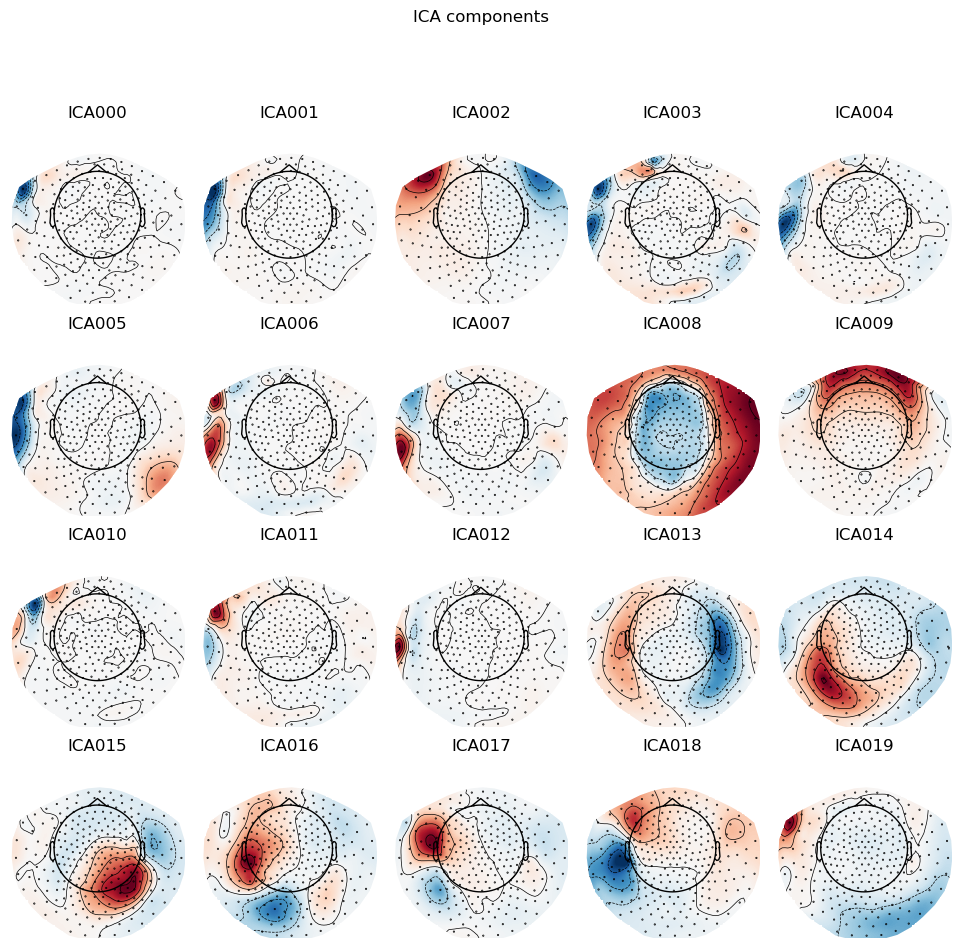

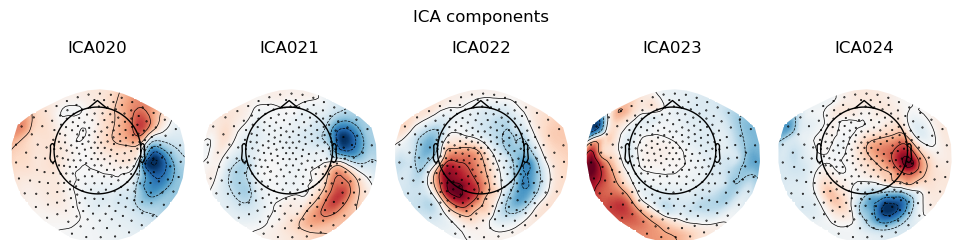

Creating RawArray with float64 data, n_channels=25, n_times=288000
    Range : 0 ... 287999 =      0.000 ...   479.998 secs
Ready.
Using pyopengl with version 3.1.6


In [29]:
# run ICA
filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)
# select EEG channels
filt_raw.pick_types(meg=True)

# ICA - Only computing the 25 first components for speed issue, using 42 as a random seed
ica = mne.preprocessing.ICA(n_components=25, max_iter=1000, random_state=42)

# applying ICA only to EEG channels only, to filtered raw
ica.fit(filt_raw)
ica.plot_components(picks=None, ch_type='mag')
ica.plot_sources(filt_raw)

In [35]:
bad_components = [0, 1, 2, 9, 12]

In [36]:
ica.exclude = bad_components
postica = ica.apply(raw)
preproc = postica.filter(l_freq=.1, h_freq=48)



Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 266 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 48.00 Hz
- Upper transition bandwidth: 12.00 Hz (-6 dB cutoff frequency: 54.00 Hz)
- Filter length: 19801 samples (33.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:    2.4s finished


In [88]:
epochs

<Epochs |  239 events (all good), -2 – 2 s, baseline off, ~1.25 GB, data loaded,
 'RESP/LONG': 93
 'RESP/SHORT': 27
 'STIM/LONG': 93
 'STIM/SHORT': 26>

In [91]:
stim_epochs = epochs['STIM/LONG', 'STIM/SHORT']
stim_epochs

<Epochs |  119 events (all good), -2 – 2 s, baseline off, ~639.1 MB, data loaded,
 'STIM/LONG': 93
 'STIM/SHORT': 26>

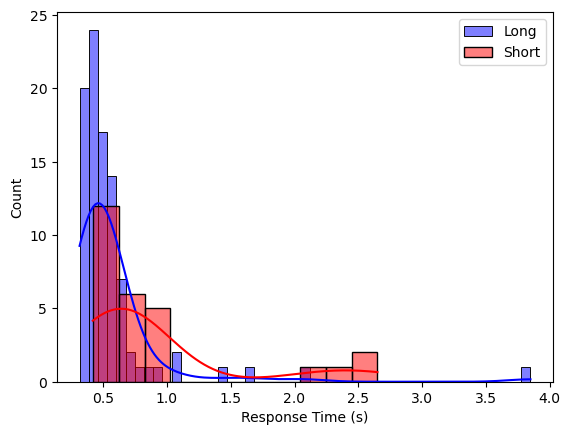

In [92]:
events, event_id = mne.annotations.events_from_annotations(preproc)
epochs = mne.Epochs(raw, events=events, picks = 'meg', event_id = event_id, tmin=-2, tmax=2, baseline = None, event_repeated='merge', preload = True)

# Map event IDs
stim_ids = [event_id['STIM/LONG'], event_id['STIM/SHORT']]
resp_ids = [event_id['RESP/LONG'], event_id['RESP/SHORT']]

stim_epochs = epochs['STIM/LONG', 'STIM/SHORT']
resp_epochs = epochs['RESP/LONG', 'RESP/SHORT']

# Initialize lists for RTs
rt_long_isi = []
rt_short_isi = []

# Loop through events and calculate RTs
for i, (event_time, _, event_type) in enumerate(events):
    if event_type in resp_ids:  # Check if it's a RESP event
        # Find the nearest preceding STIM event
        for prev_time, _, prev_type in events[:i][::-1]:
            if prev_type in stim_ids:
                rt = (event_time - prev_time) / preproc.info['sfreq']  # Compute RT in seconds
                if prev_type == event_id['STIM/LONG']:
                    rt_long_isi.append(rt)
                elif prev_type == event_id['STIM/SHORT']:
                    rt_short_isi.append(rt)
                break

# Convert to numpy arrays
rt_long_isi = np.array(rt_long_isi)
rt_short_isi = np.array(rt_short_isi)

# plot the distribution of RTs for each condition
fig, ax = plt.subplots()
sns.histplot(rt_long_isi, kde=True, color='b', ax=ax, label='Long')
sns.histplot(rt_short_isi, kde=True, color='r', ax=ax, label='Short')
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Count')
ax.legend()
plt.show()


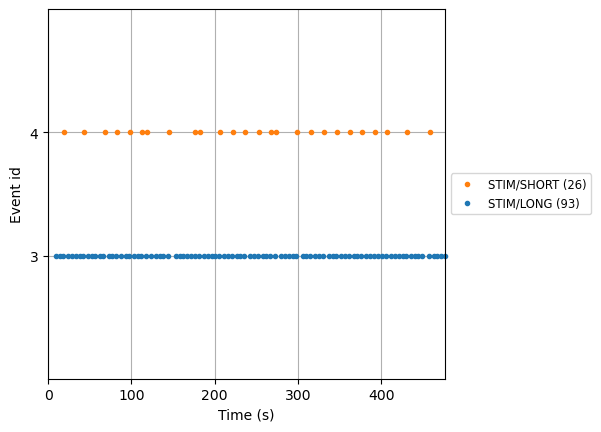

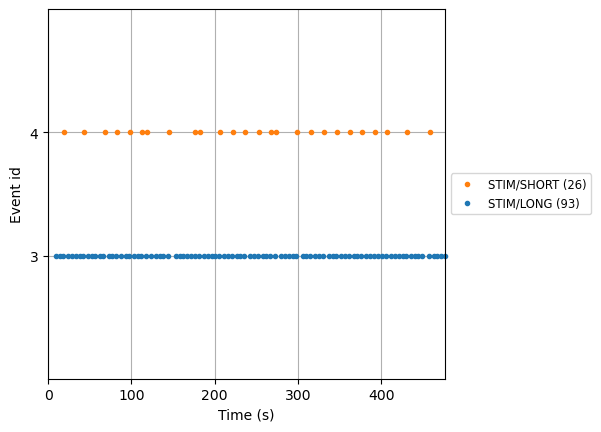

In [93]:
# Extract only STIM events
stim_events = np.array([event for event in events if event[2] in stim_ids])

# Plot STIM events with event labels
mne.viz.plot_events(stim_events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id={k: v for k, v in event_id.items() if v in stim_ids})

In [94]:
from autoreject import AutoReject
import numpy as np

# Select only STIM epochs (before applying AutoReject)

# Apply AutoReject
ar = AutoReject(cv=2, random_state=42, verbose=True)
stim_epochs_clean, reject_log = ar.fit_transform(stim_epochs, return_log=True)

# Identify rejected epochs
rejected_idx = np.where(reject_log.bad_epochs)[0]

# Get event indices for STIM_LONG and STIM_SHORT
stim_long_idx = np.where(stim_epochs.events[:, 2] == event_id['STIM/LONG'])[0]
stim_short_idx = np.where(stim_epochs.events[:, 2] == event_id['STIM/SHORT'])[0]

# Create mapping between STIM_SHORT and corresponding STIM_LONG trials
paired_trials = {}  # Key: STIM_SHORT index, Value: Corresponding STIM_LONG index
for short_idx in stim_short_idx:
    # Find the closest preceding STIM_LONG
    corresponding_long_idx = max([idx for idx in stim_long_idx if idx < short_idx], default=None)
    if corresponding_long_idx is not None:
        paired_trials[short_idx] = corresponding_long_idx

# Identify STIM_LONG indices that should be removed
long_to_remove = set()
for short_idx in rejected_idx:
    if short_idx in paired_trials:  # If the rejected epoch is a STIM_SHORT
        long_to_remove.add(paired_trials[short_idx])  # Remove corresponding STIM_LONG

# Combine indices to remove
to_remove = sorted(set(rejected_idx) | long_to_remove)

# Remove them from the epochs
stim_epochs_clean = stim_epochs.drop(to_remove, reason="Linked STIM_SHORT rejected")



Running autoreject on ch_type=mag




Estimated consensus=0.30 and n_interpolate=32


In [106]:
print(STIM_short_tfr.data.shape)  # Expected (n_epochs, n_channels, n_freqs, n_times)


(18, 6, 39, 2401)


In [ ]:
stim_epochs = epochs['STIM/LONG', 'STIM/SHORT']
stim_epochs

<Epochs |  119 events (all good), -2 – 2 s, baseline off, ~639.1 MB, data loaded,
 'STIM/LONG': 93
 'STIM/SHORT': 26>

In [ ]:
# find a way to use the baseline for the corresponding long epoch to use it for the short epoch

# Analysis for STIM epochs

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


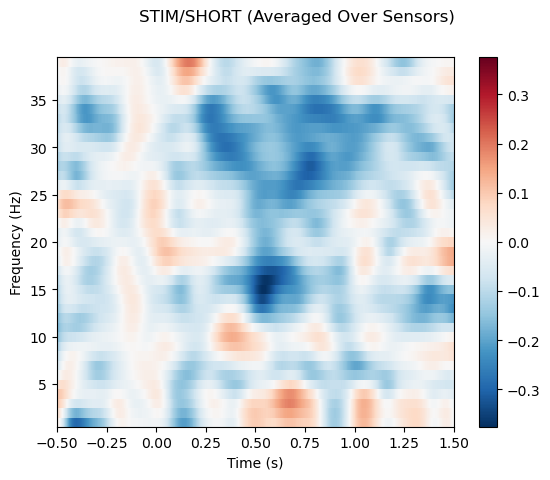

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


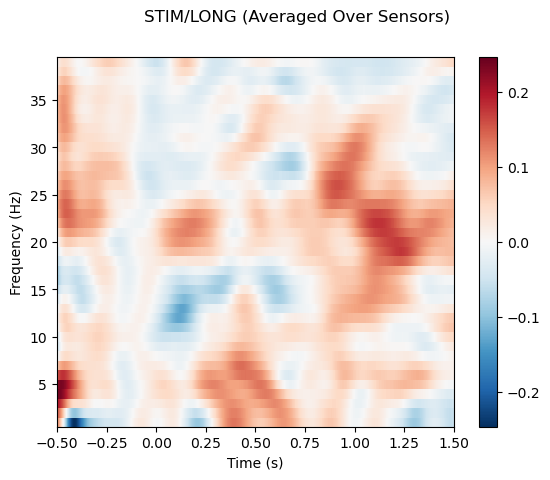

[<Figure size 640x480 with 2 Axes>]

In [39]:
bursts_all_results_stim = []

# Define conditions
conditions = {'short': epochs['STIM/SHORT'], 'long': epochs['STIM/LONG']}
rts = {'short': rt_short_isi, 'long': rt_long_isi}  # Reaction times for each condition

# Burst extraction and analysis
for condition_name, condition in conditions.items():
    for sensor in sensors:
        # Get data for the current sensor
        times = condition.times
        ch_idx = condition.ch_names.index(sensor)
        trials = condition.get_data()[:, ch_idx, :]

        sfreq = condition.info['sfreq']
        max_freq = 120
        foi = np.linspace(1, max_freq, 120)
        scales = scale_from_period(1 / foi)

        tf_trials = []

        # Compute time-frequency analysis
        for trial in trials:
            tf = superlet(trial, sfreq, scales, 40, c_1=4, adaptive=True)
            tf_trials.append(np.single(np.abs(tf)))
        tf_trials = np.array(tf_trials)

        # Compute average power spectral density (PSD)
        average_psd = np.average(tf_trials, axis=(2, 0))

        # Fit the 1/f-like background
        ff = FOOOF()
        ff.fit(foi, average_psd, [1, 120])
        ap = 10 ** ff._ap_fit  # Aperiodic component

        # Extract bursts
        search_range = np.where((foi >= 10) & (foi <= 33))[0]
        beta_lims = [13, 30]
        bursts = extract_bursts(
            trials, tf_trials[:, search_range], times, 
            foi[search_range], beta_lims, 
            ap[search_range].reshape(-1, 1), sfreq
        )

        # Add metadata to bursts
        bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
        bursts['sensor'] = np.tile(sensor, bursts['trial'].shape)
        bursts['subject'] = np.tile(subject, bursts['trial'].shape)
        bursts['group'] = np.tile(group, bursts['trial'].shape)
        bursts['epochs'] = np.tile('stim', bursts['trial'].shape)

        # Append results
        bursts_all_results_stim.append(bursts)

        # # Plot burst waveforms
        # f, ax = plt.subplots(1, 1, figsize=(5, 5))
        # mean_waveform = np.mean(bursts["waveform"], axis=0)
        # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2)
        # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black")
        # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
        # ax.set_title(f"{condition_name} - sensor {sensor}")

        waveform_times = bursts_all_results_stim[0]["waveform_times"]

path = '/Users/quentinmoreau/Documents/Work/gaetz_bursts/first_results/'
# save bursts_all_results_stim as npy
np.save(f'{path}bursts_all_results_stim_{subject}.npy', bursts_all_results_stim)

# save waveform_times
np.save(f'{path}/waveform_times.npy', waveform_times)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

/var/folders/6s/2qfkp2515r7f660tnsjg8t440000gq/T/ipykernel_15590/2496408747.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


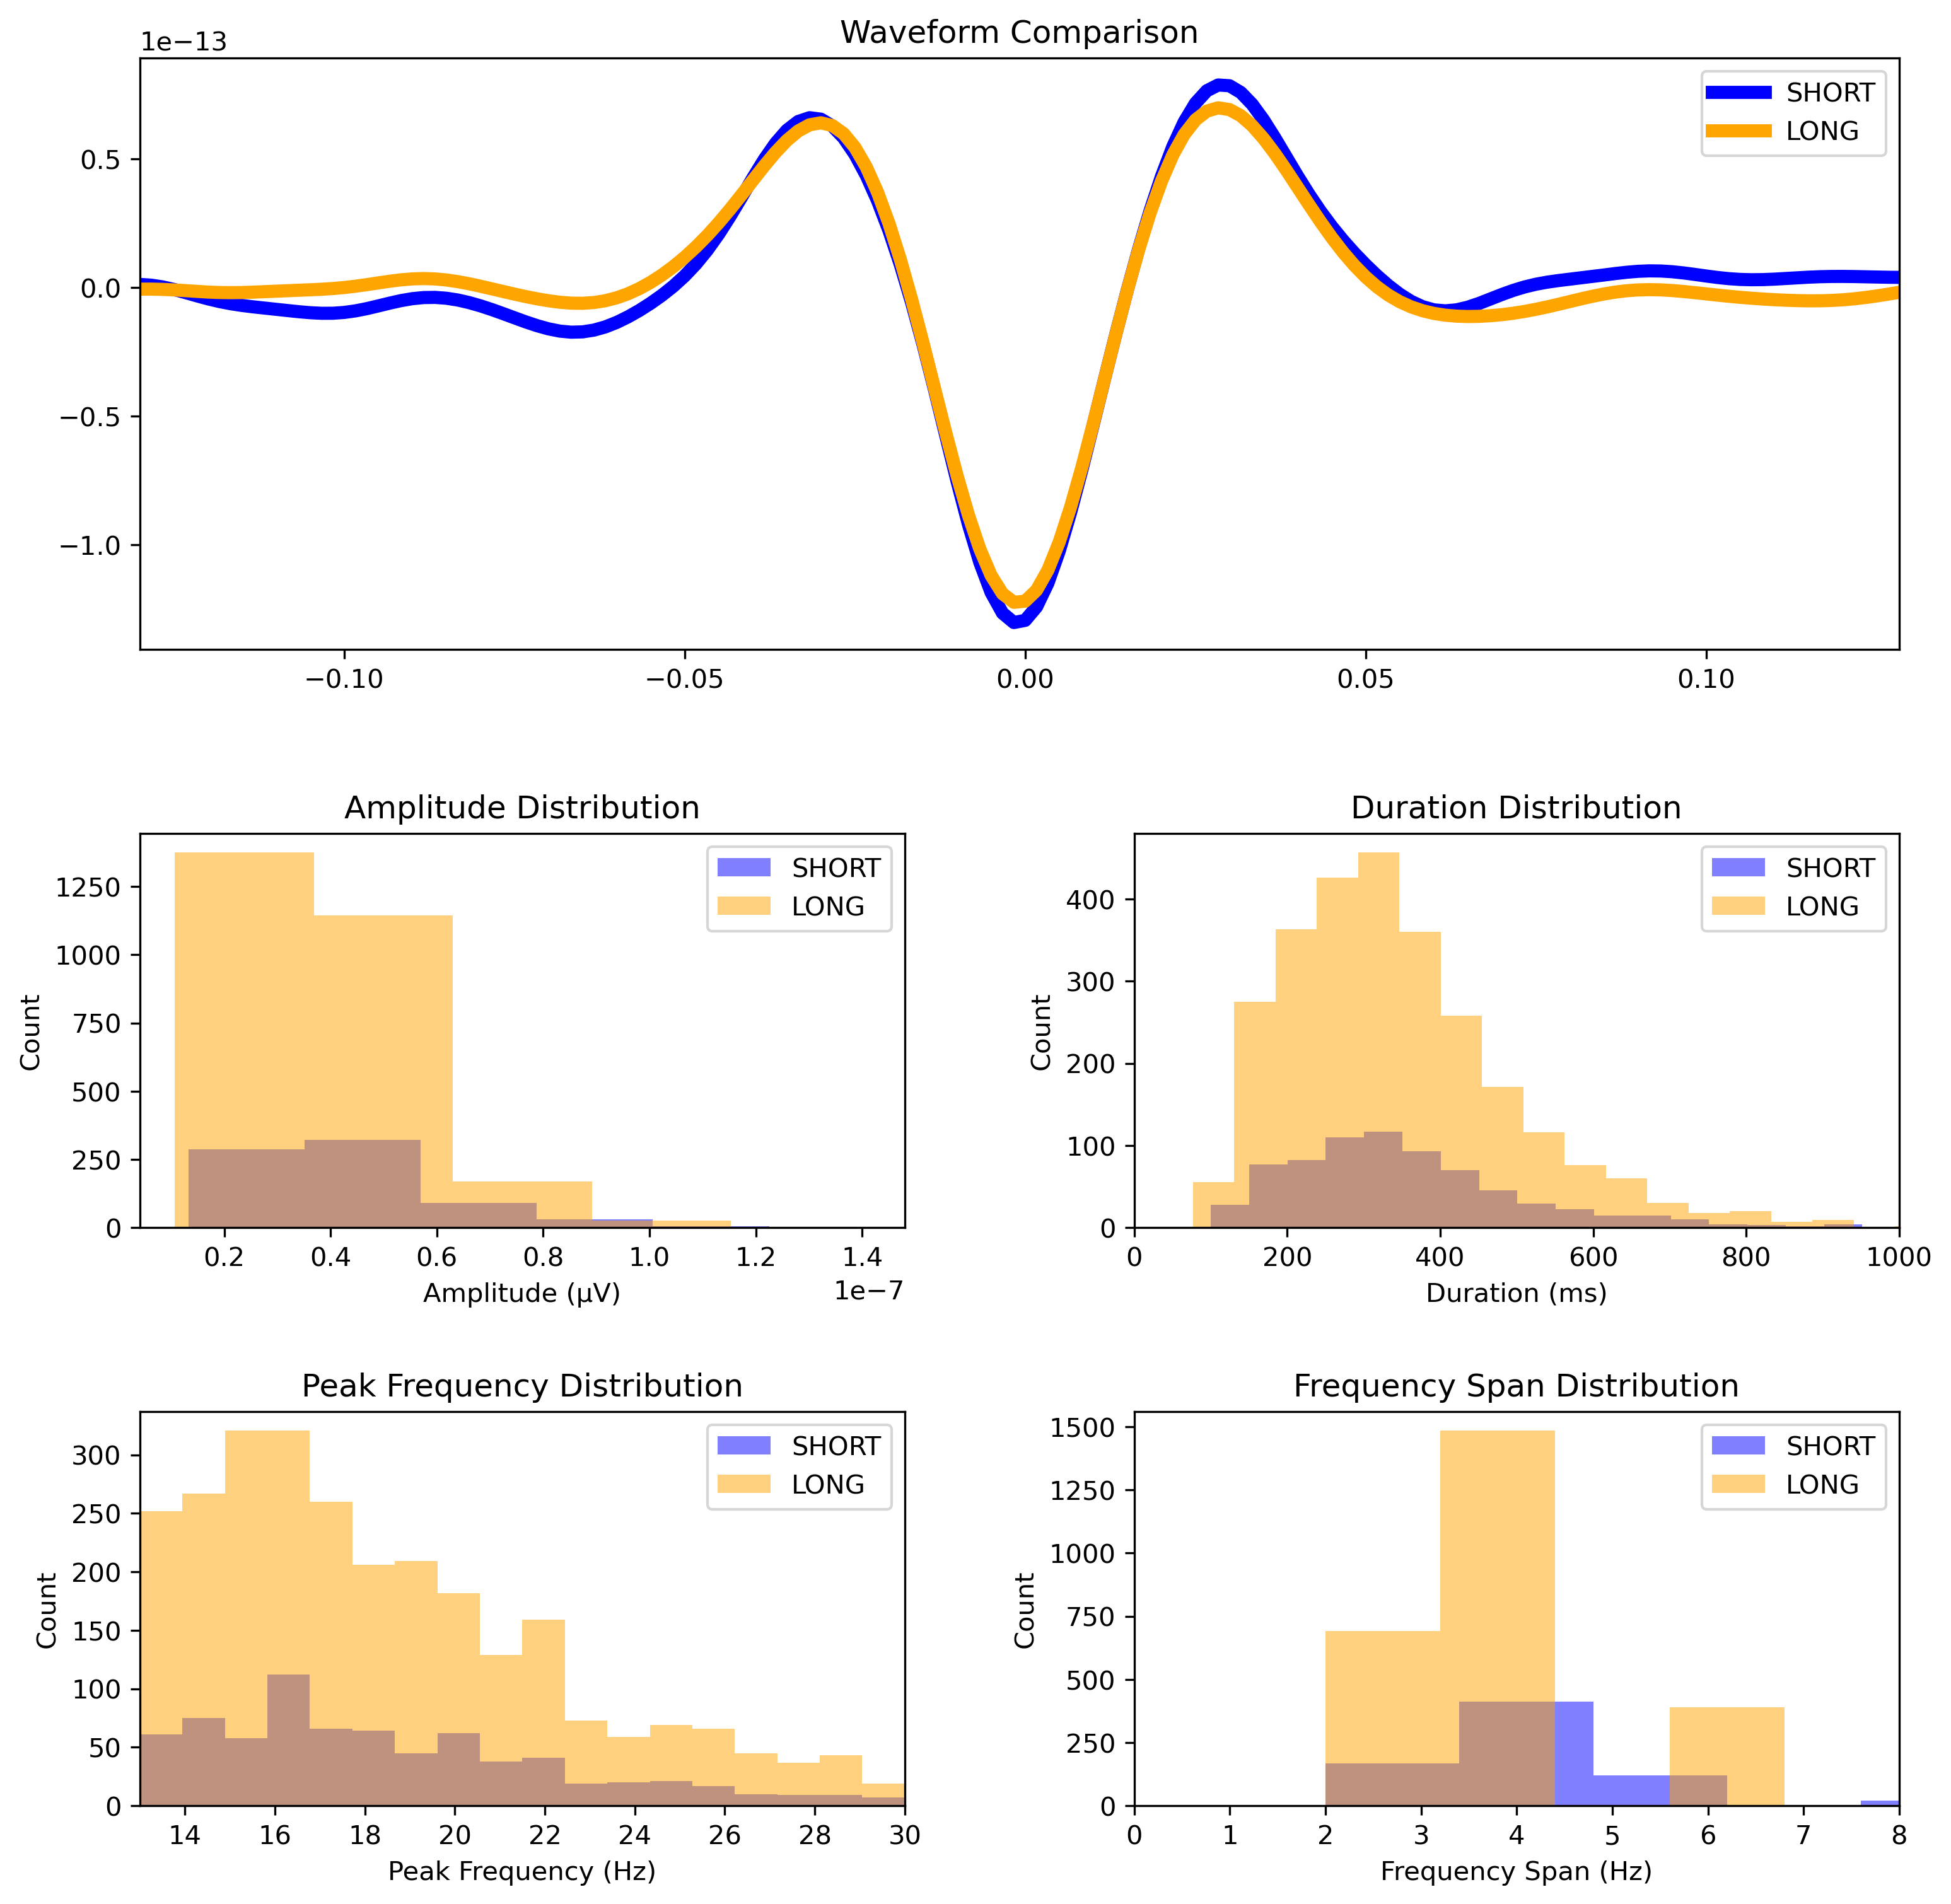

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Prepare the figure with GridSpec layout
fig = plt.figure(figsize=(12, 12), dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 1, 1], hspace=0.4, wspace=0.3)

# Filter bursts by condition
bursts_short = [burst for burst in bursts_all_results_stim if burst['condition'][0] == 'short']
bursts_long = [burst for burst in bursts_all_results_stim if burst['condition'][0] == 'long']

# Waveform comparison plot (spans the first row)
ax0 = fig.add_subplot(gs[0, :])  # Span all columns
waveforms_short = [burst["waveform"] for burst in bursts_short]
waveforms_long = [burst["waveform"] for burst in bursts_long]
mean_waveform_short = np.mean(np.concatenate(waveforms_short, axis=0), axis=0)
mean_waveform_long = np.mean(np.concatenate(waveforms_long, axis=0), axis=0)
ax0.plot(waveform_times, mean_waveform_short, lw=5, c="blue", label='SHORT')
ax0.plot(waveform_times, mean_waveform_long, lw=5, c="orange", label='LONG')
ax0.set_title("Waveform Comparison")
ax0.set_xlim(waveform_times[0], waveform_times[-1])
ax0.legend()

# Amplitude distribution (top left of second row)
ax1 = fig.add_subplot(gs[1, 0])
amplitudes_short = np.concatenate([burst['peak_amp_base'] for burst in bursts_short]) * 1e6  # Convert to µV
amplitudes_long = np.concatenate([burst['peak_amp_base'] for burst in bursts_long]) * 1e6  # Convert to µV
ax1.hist(amplitudes_short, bins=5, alpha=0.5, color="blue", label="SHORT")
ax1.hist(amplitudes_long, bins=5, alpha=0.5, color="orange", label="LONG")
ax1.set_title("Amplitude Distribution")
ax1.set_xlabel("Amplitude (µV)")
# ax1.set_xlim(0, 4000)
ax1.set_ylabel("Count")
ax1.legend()

# Duration distribution (top right of second row)
ax2 = fig.add_subplot(gs[1, 1])
durations_short = np.concatenate([burst['fwhm_time'] for burst in bursts_short]) * 1e3  # Convert to ms
durations_long = np.concatenate([burst['fwhm_time'] for burst in bursts_long]) * 1e3  # Convert to ms
ax2.hist(durations_short, bins=30, alpha=0.5, color="blue", label="SHORT")
ax2.hist(durations_long, bins=30, alpha=0.5, color="orange", label="LONG")
ax2.set_title("Duration Distribution")
ax2.set_xlabel("Duration (ms)")
ax2.set_xlim(0, 1000)
ax2.set_ylabel("Count")
ax2.legend()

# Peak frequency distribution (bottom left)
ax3 = fig.add_subplot(gs[2, 0])
peak_freq_short = np.concatenate([burst['peak_freq'] for burst in bursts_short])
peak_freq_long = np.concatenate([burst['peak_freq'] for burst in bursts_long])
ax3.hist(peak_freq_short, bins=18, alpha=0.5, color="blue", label="SHORT")
ax3.hist(peak_freq_long, bins=18, alpha=0.5, color="orange", label="LONG")
ax3.set_title("Peak Frequency Distribution")
ax3.set_xlabel("Peak Frequency (Hz)")
ax3.set_ylabel("Count")
ax3.set_xlim(13, 30)
ax3.legend()

# Frequency span distribution (bottom right)
ax4 = fig.add_subplot(gs[2, 1])
freq_span_short = np.concatenate([burst['fwhm_freq'] for burst in bursts_short])
freq_span_long = np.concatenate([burst['fwhm_freq'] for burst in bursts_long])
ax4.hist(freq_span_short, bins=10, alpha=0.5, color="blue", label="SHORT")
ax4.hist(freq_span_long, bins=10, alpha=0.5, color="orange", label="LONG")
ax4.set_title("Frequency Span Distribution")
ax4.set_xlim(0, 8)
ax4.set_xlabel("Frequency Span (Hz)")
ax4.set_ylabel("Count")
ax4.legend()

plt.tight_layout()
plt.show()


# Analysis for RESP epochs

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


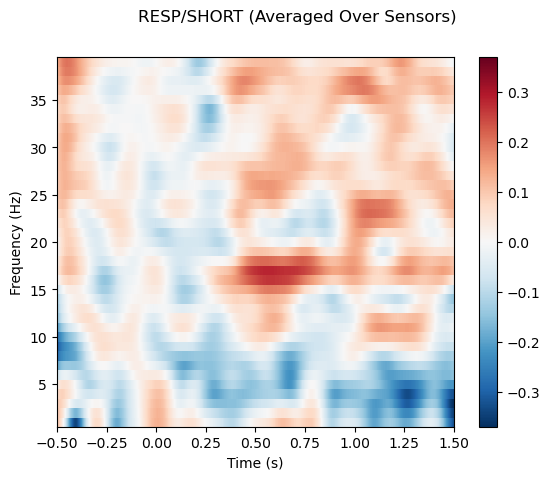

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


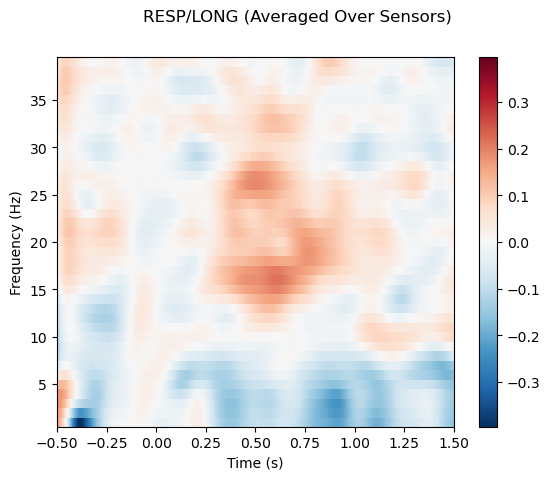

[<Figure size 640x480 with 2 Axes>]

In [41]:
RESP_short = epochs['RESP/SHORT']
RESP_long = epochs['RESP/LONG']

# Compute time-frequency analysis for RESP condition
RESP_short_tfr = mne.time_frequency.tfr_morlet(RESP_short, freqs=frequencies, n_cycles=n_cycles, use_fft=True, picks=sensors, return_itc=False, decim=1, n_jobs=1, verbose=None)
RESP_long_tfr = mne.time_frequency.tfr_morlet(RESP_long, freqs=frequencies, n_cycles=n_cycles, use_fft=True, picks=sensors, return_itc=False, decim=1, n_jobs=1, verbose=None)


# save the subject's tfr
file_path = '/Users/quentinmoreau/Documents/Work/gaetz_bursts/first_results/'
RESP_short_tfr_name = file_path + subject + '_RESP_short_tfr.h5'
mne.time_frequency.write_tfrs(RESP_short_tfr_name, RESP_short_tfr, overwrite=True)

RESP_long_tfr_name = file_path + subject + '_RESP_long_tfr.h5'
mne.time_frequency.write_tfrs(RESP_long_tfr_name, RESP_long_tfr, overwrite=True)

# Plot averaged TFR for RESP/SHORT
fig, ax = plt.subplots()
RESP_short_tfr.plot('all', baseline=(-.2, 0), mode='logratio', tmax=1.5, title='RESP/SHORT (Averaged Over Sensors)', axes=ax, colorbar=True, combine='mean')

# Plot averaged TFR for RESP/LONG
fig, ax = plt.subplots()
RESP_long_tfr.plot('all', baseline=(-.2, 0), mode='logratio', tmax=1.5, title='RESP/LONG (Averaged Over Sensors)', axes=ax, colorbar=True, combine='mean')


In [42]:
bursts_all_results_resp = []

# Configuration
sensors = ["MLC11", "MLC25", "MLC32", "MLC42", "MLC54", "MLC55"]
subject_id = 'COM033'

frequencies = np.arange(1, 40, 1)
n_cycles = frequencies / 2

# Define conditions
conditions = {'short': epochs['RESP/SHORT'], 'long': epochs['RESP/LONG']}

# Burst extraction and analysis
for condition_name, condition in conditions.items():
    for sensor in sensors:
        # Get data for the current sensor
        times = condition.times
        ch_idx = condition.ch_names.index(sensor)
        trials = condition.get_data()[:, ch_idx, :]

        sfreq = condition.info['sfreq']
        max_freq = 120
        foi = np.linspace(1, max_freq, 120)
        scales = scale_from_period(1 / foi)

        tf_trials = []

        # Compute time-frequency analysis
        for trial in trials:
            tf = superlet(trial, sfreq, scales, 40, c_1=4, adaptive=True)
            tf_trials.append(np.single(np.abs(tf)))
        tf_trials = np.array(tf_trials)

        # Compute average power spectral density (PSD)
        average_psd = np.average(tf_trials, axis=(2, 0))

        # Fit the 1/f-like background
        ff = FOOOF()
        ff.fit(foi, average_psd, [1, 120])
        ap = 10 ** ff._ap_fit  # Aperiodic component

        # Extract bursts
        search_range = np.where((foi >= 10) & (foi <= 33))[0]
        beta_lims = [13, 30]
        bursts = extract_bursts(
            trials, tf_trials[:, search_range], times, 
            foi[search_range], beta_lims, 
            ap[search_range].reshape(-1, 1), sfreq
        )

        # Add metadata to bursts
        bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
        bursts['sensor'] = np.tile(sensor, bursts['trial'].shape)
        bursts['subject'] = np.tile(subject_id, bursts['trial'].shape)
        bursts['group'] = np.tile('TD', bursts['trial'].shape)
        bursts['epochs'] = np.tile('resp', bursts['trial'].shape)

        # Append results
        bursts_all_results_resp.append(bursts)

        # # Plot burst waveforms
        # f, ax = plt.subplots(1, 1, figsize=(5, 5))
        # mean_waveform = np.mean(bursts["waveform"], axis=0)
        # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2)
        # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black")
        # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
        # ax.set_title(f"{condition_name} - sensor {sensor}")

        waveform_times = bursts_all_results_resp[0]["waveform_times"]


path = '/Users/quentinmoreau/Documents/Work/gaetz_bursts/first_results/'
# save bursts_all_results_resp as npy
np.save(f'{path}bursts_all_results_resp_{subject}.npy', bursts_all_results_stim)

# save waveform_times
np.save(f'{path}/waveform_times.npy', waveform_times)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

/var/folders/6s/2qfkp2515r7f660tnsjg8t440000gq/T/ipykernel_15590/1462004826.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


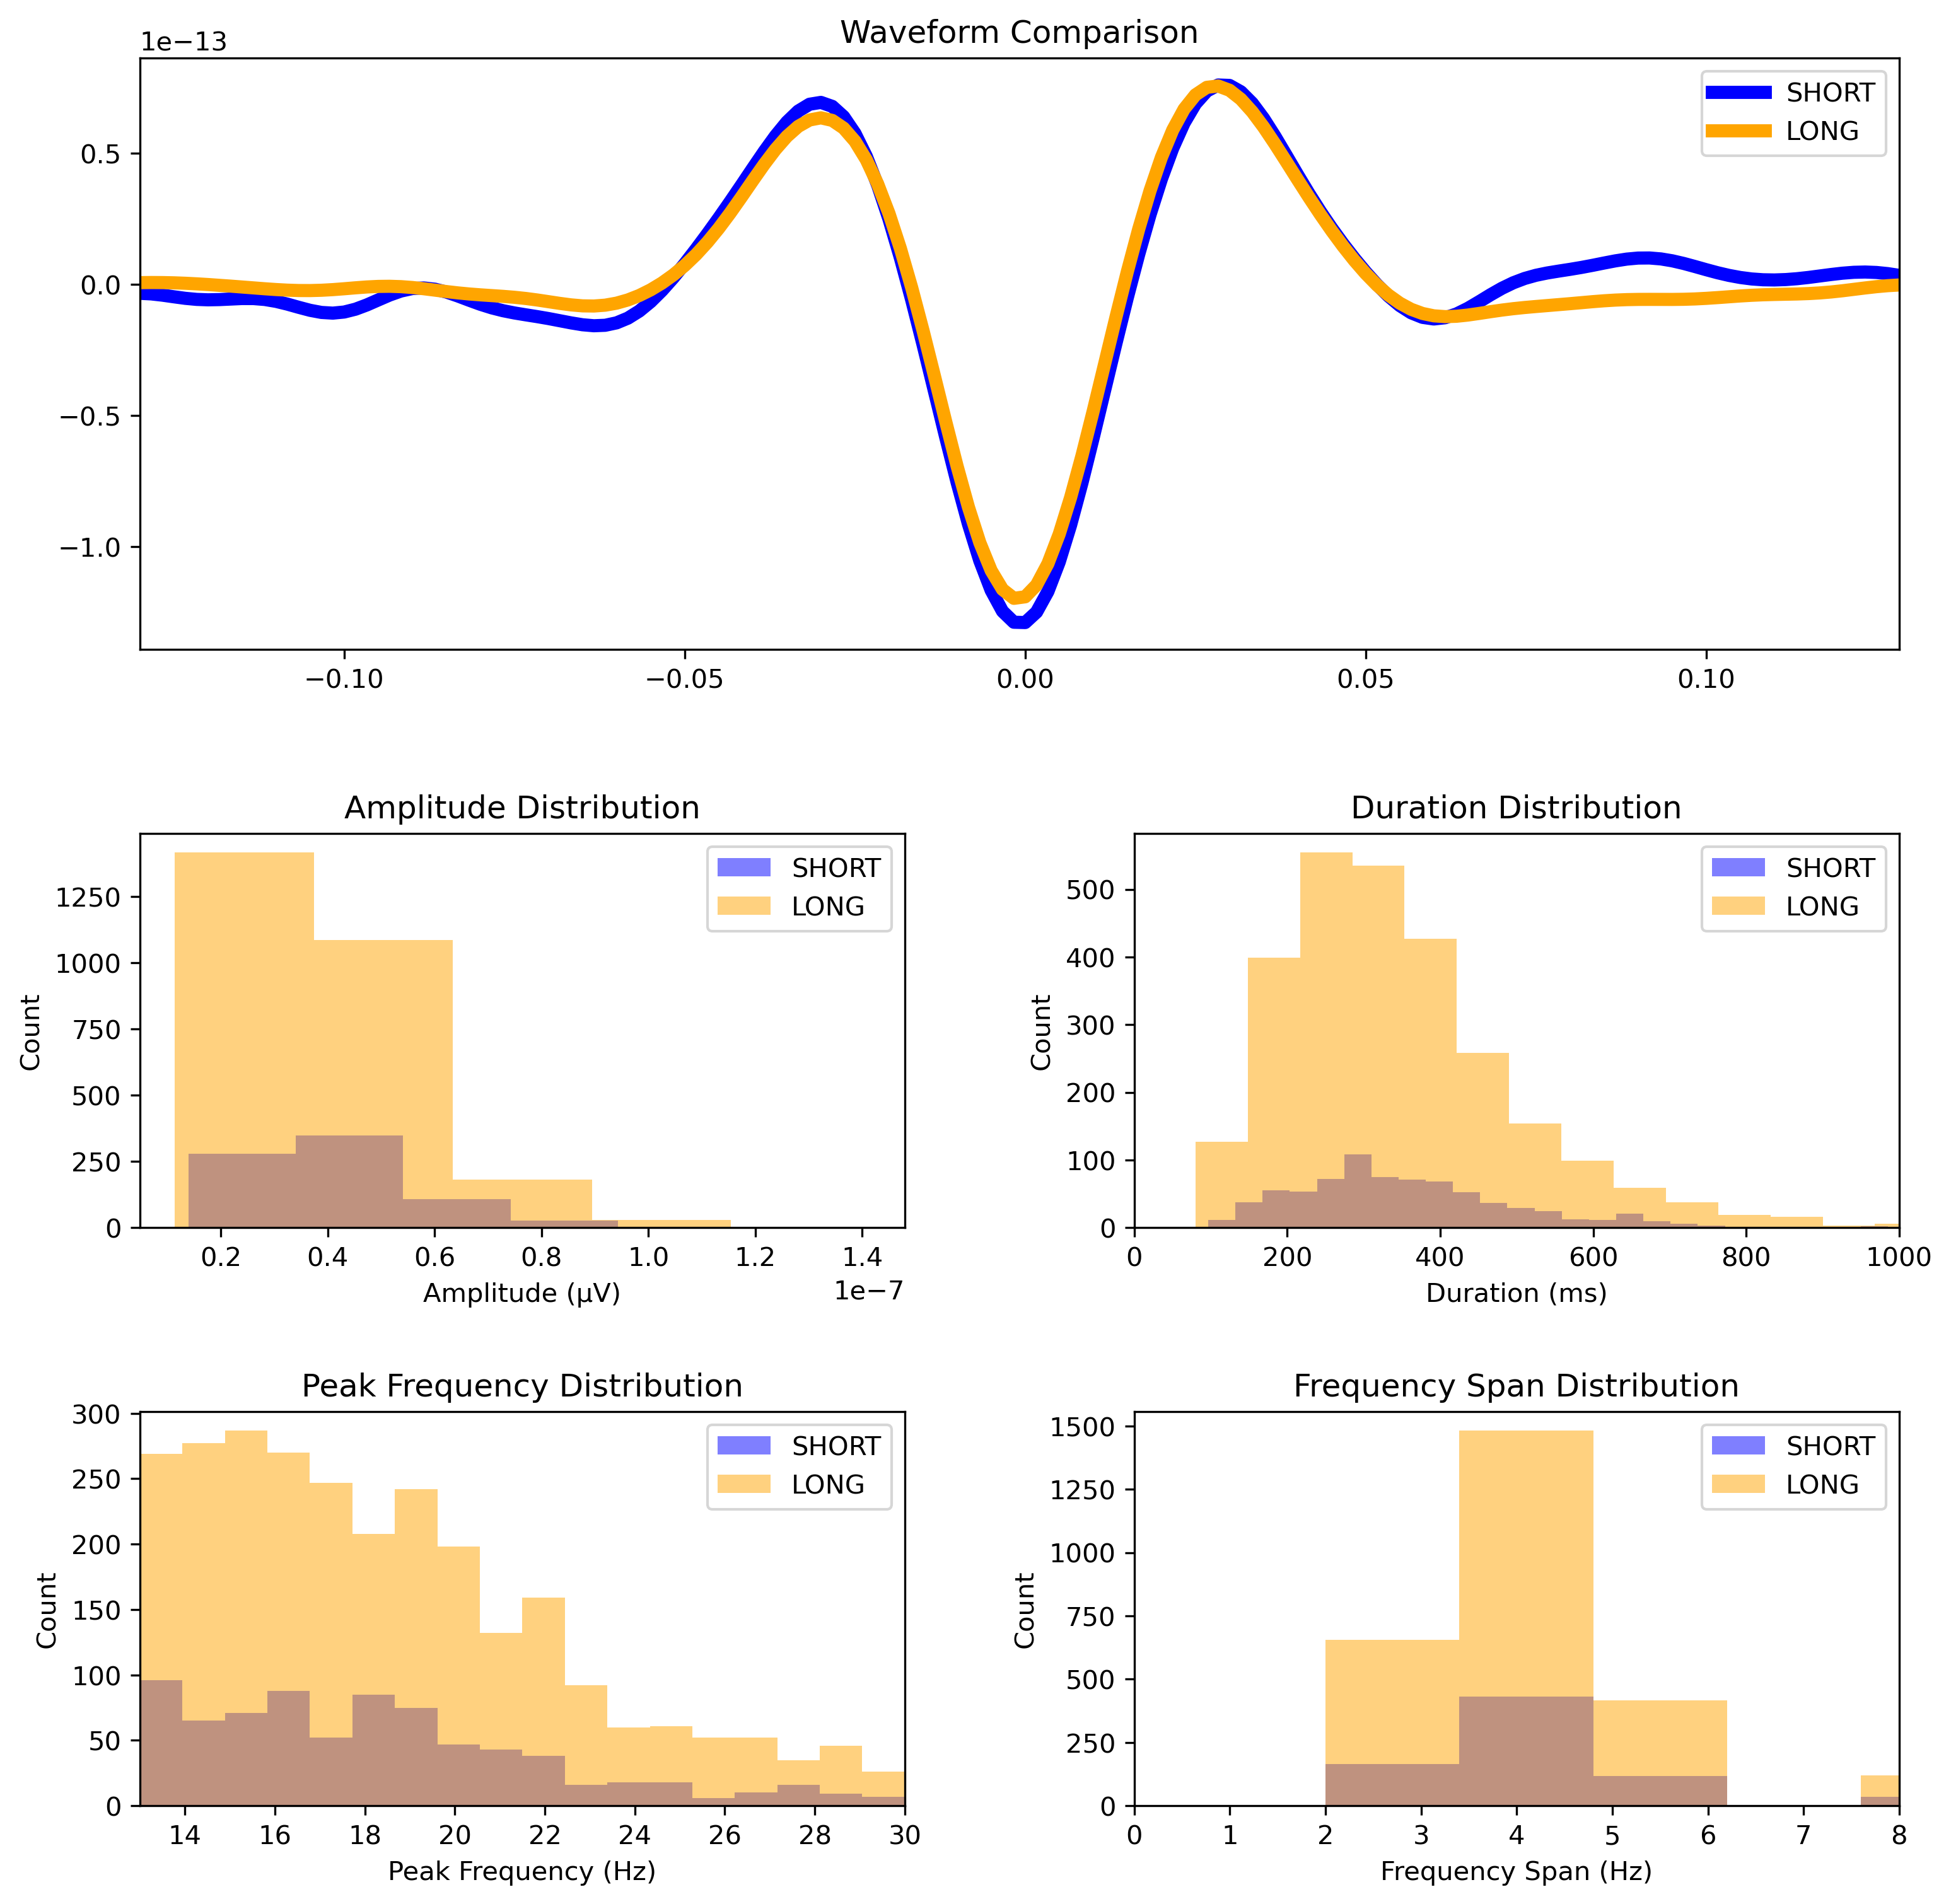

In [ ]:
# Prepare the figure with GridSpec layout
fig = plt.figure(figsize=(12, 12), dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 1, 1], hspace=0.4, wspace=0.3)

# Filter bursts by condition
bursts_short = [burst for burst in bursts_all_results_resp if burst['condition'][0] == 'short']
bursts_long = [burst for burst in bursts_all_results_resp if burst['condition'][0] == 'long']

# Waveform comparison plot (spans the first row)
ax0 = fig.add_subplot(gs[0, :])  # Span all columns
waveforms_short = [burst["waveform"] for burst in bursts_short]
waveforms_long = [burst["waveform"] for burst in bursts_long]
mean_waveform_short = np.mean(np.concatenate(waveforms_short, axis=0), axis=0)
mean_waveform_long = np.mean(np.concatenate(waveforms_long, axis=0), axis=0)
ax0.plot(waveform_times, mean_waveform_short, lw=5, c="blue", label='SHORT')
ax0.plot(waveform_times, mean_waveform_long, lw=5, c="orange", label='LONG')
ax0.set_title("Waveform Comparison")
ax0.set_xlim(waveform_times[0], waveform_times[-1])
ax0.legend()

# Amplitude distribution (top left of second row)
ax1 = fig.add_subplot(gs[1, 0])
amplitudes_short = np.concatenate([burst['peak_amp_base'] for burst in bursts_short]) * 1e6  # Convert to µV
amplitudes_long = np.concatenate([burst['peak_amp_base'] for burst in bursts_long]) * 1e6  # Convert to µV
ax1.hist(amplitudes_short, bins=5, alpha=0.5, color="blue", label="SHORT")
ax1.hist(amplitudes_long, bins=5, alpha=0.5, color="orange", label="LONG")
ax1.set_title("Amplitude Distribution")
ax1.set_xlabel("Amplitude (µV)")
# ax1.set_xlim(0, 4000)
ax1.set_ylabel("Count")
ax1.legend()

# Duration distribution (top right of second row)
ax2 = fig.add_subplot(gs[1, 1])
durations_short = np.concatenate([burst['fwhm_time'] for burst in bursts_short]) * 1e3  # Convert to ms
durations_long = np.concatenate([burst['fwhm_time'] for burst in bursts_long]) * 1e3  # Convert to ms
ax2.hist(durations_short, bins=30, alpha=0.5, color="blue", label="SHORT")
ax2.hist(durations_long, bins=30, alpha=0.5, color="orange", label="LONG")
ax2.set_title("Duration Distribution")
ax2.set_xlabel("Duration (ms)")
ax2.set_xlim(0, 1000)
ax2.set_ylabel("Count")
ax2.legend()

# Peak frequency distribution (bottom left)
ax3 = fig.add_subplot(gs[2, 0])
peak_freq_short = np.concatenate([burst['peak_freq'] for burst in bursts_short])
peak_freq_long = np.concatenate([burst['peak_freq'] for burst in bursts_long])
ax3.hist(peak_freq_short, bins=18, alpha=0.5, color="blue", label="SHORT")
ax3.hist(peak_freq_long, bins=18, alpha=0.5, color="orange", label="LONG")
ax3.set_title("Peak Frequency Distribution")
ax3.set_xlabel("Peak Frequency (Hz)")
ax3.set_ylabel("Count")
ax3.set_xlim(13, 30)
ax3.legend()

# Frequency span distribution (bottom right)
ax4 = fig.add_subplot(gs[2, 1])
freq_span_short = np.concatenate([burst['fwhm_freq'] for burst in bursts_short])
freq_span_long = np.concatenate([burst['fwhm_freq'] for burst in bursts_long])

# plot densities

ax4.hist(freq_span_short, bins=10, alpha=0.5, color="blue", label="SHORT")
ax4.hist(freq_span_long, bins=10, alpha=0.5, color="orange", label="LONG")
ax4.set_title("Frequency Span Distribution")
ax4.set_xlim(0, 8)
ax4.set_xlabel("Frequency Span (Hz)")
ax4.set_ylabel("Count")
ax4.legend()

plt.tight_layout()
plt.show()


In [44]:
# combine bursts_all_results_stim and bursts_all_results_resp
bursts_all_results = bursts_all_results_stim + bursts_all_results_resp

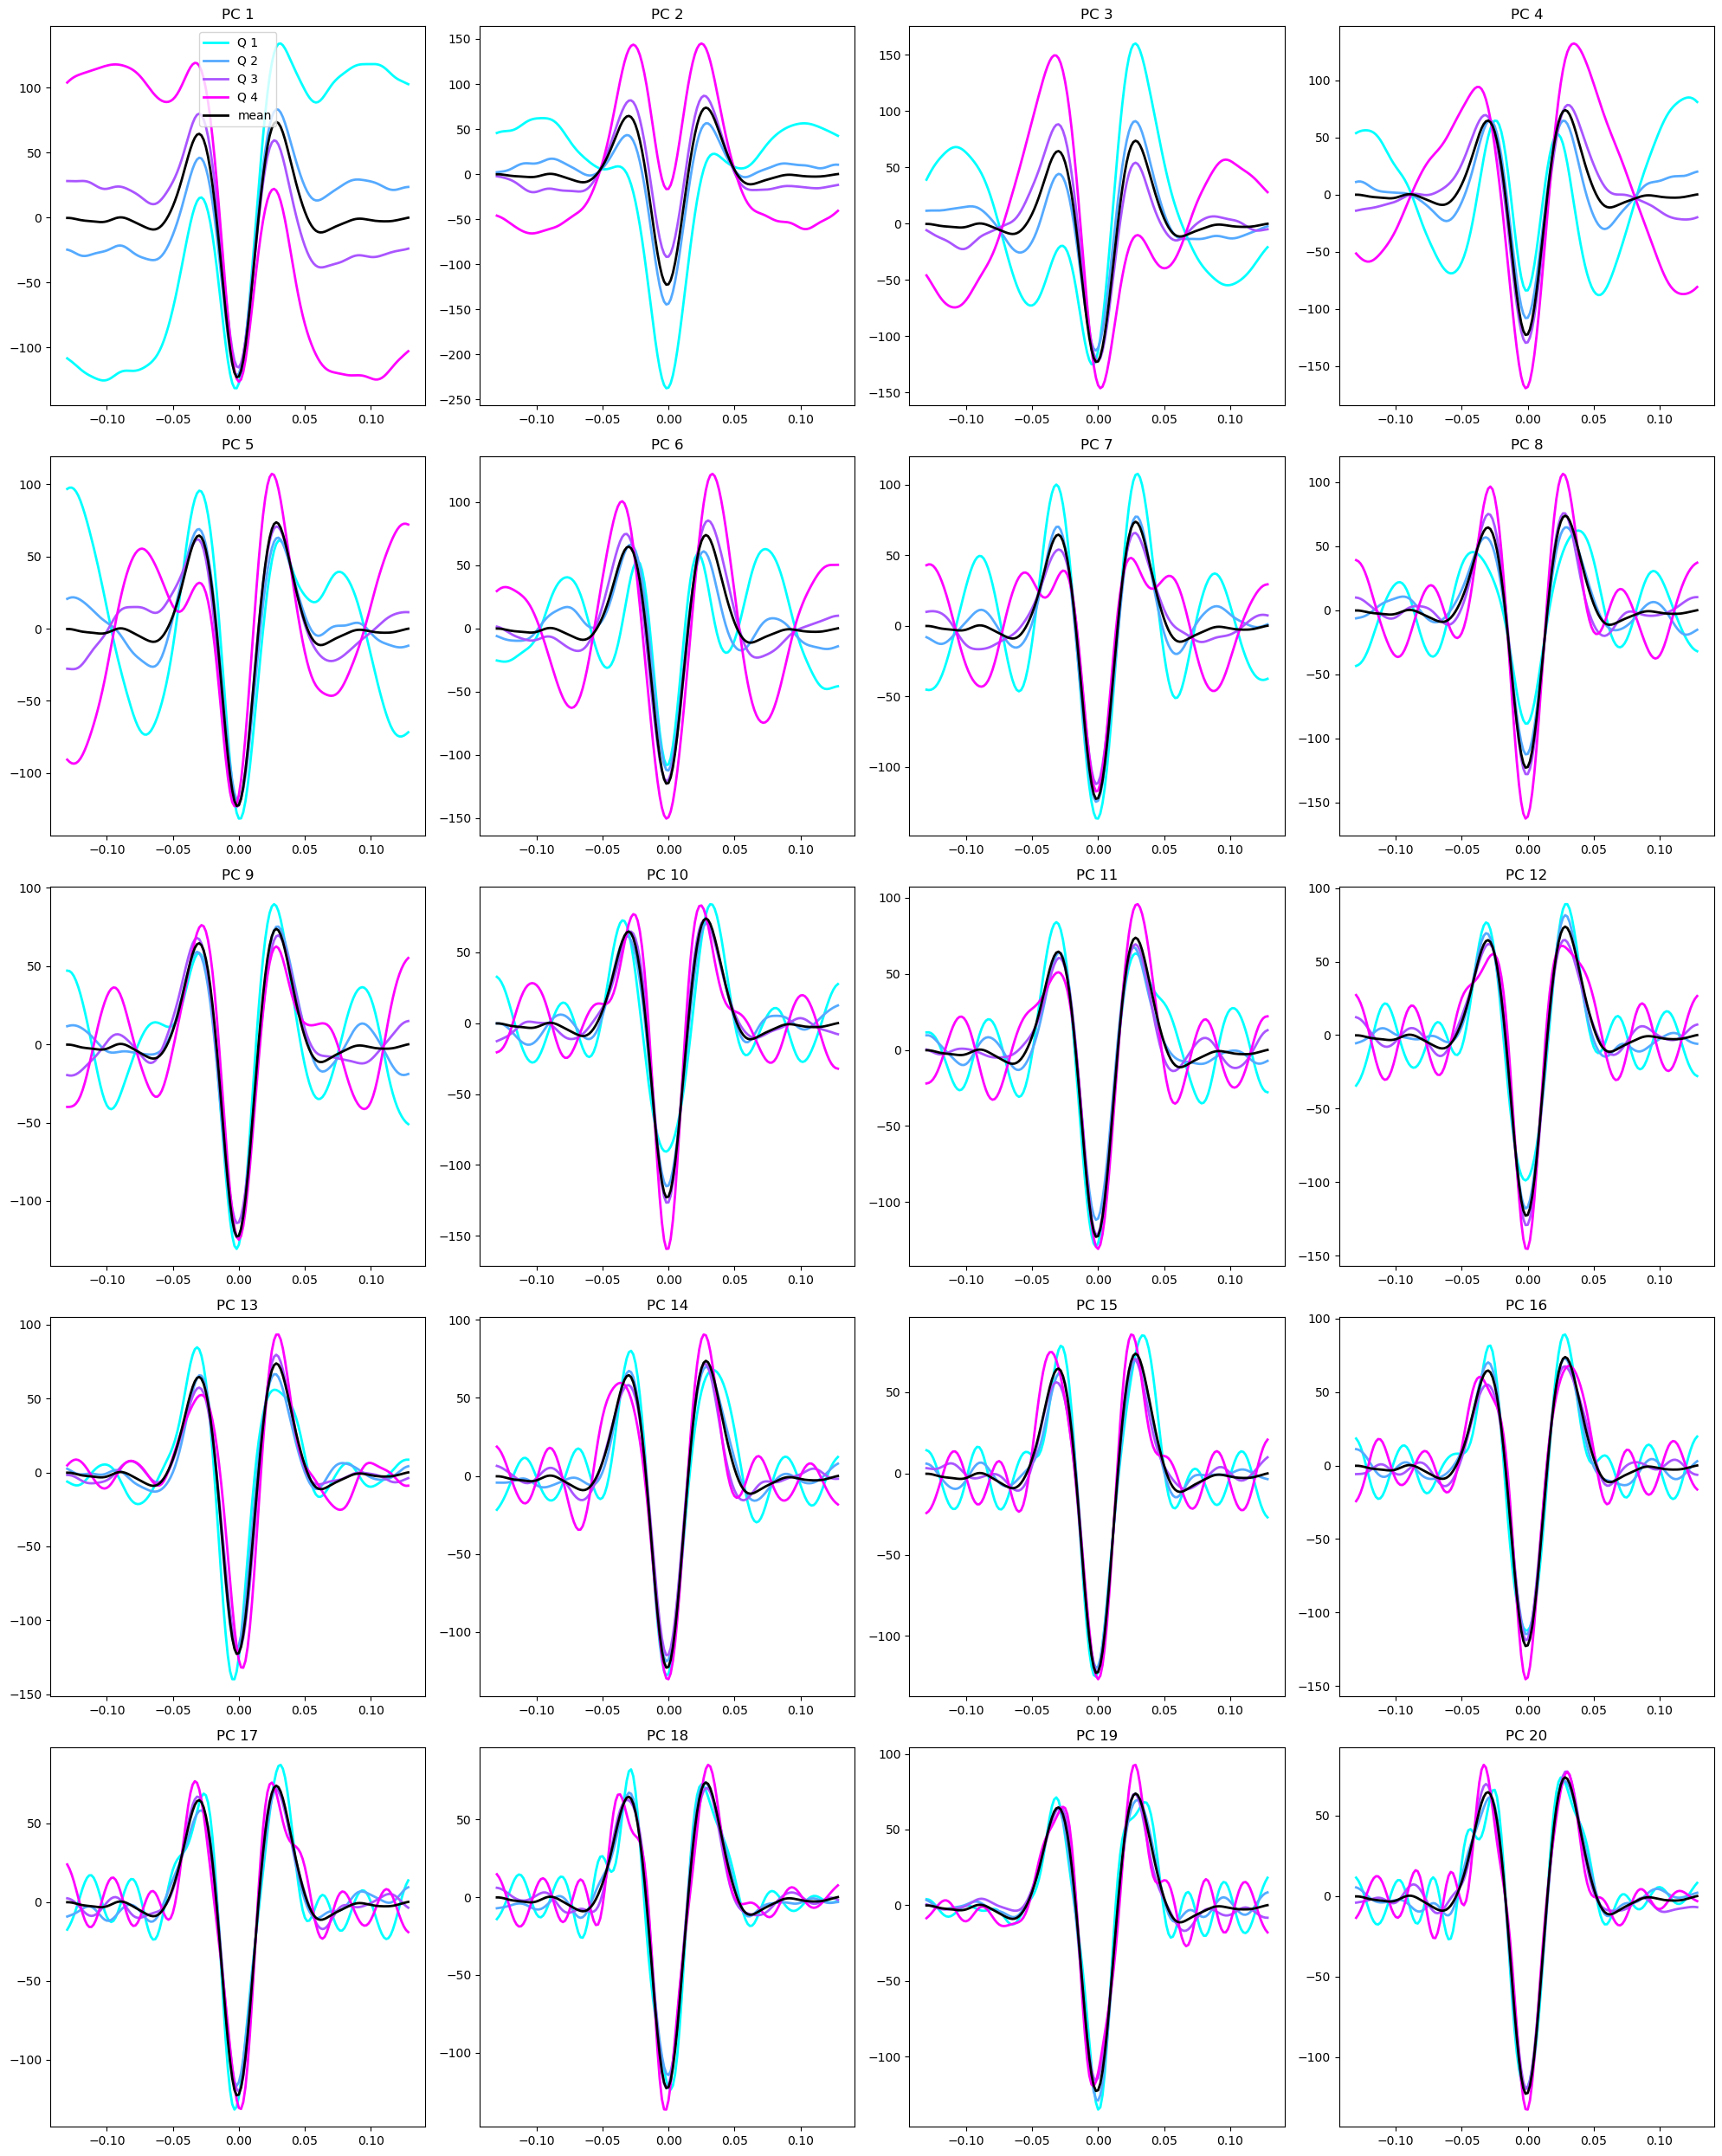

In [45]:
dict_output = {i: [] for i in bursts_all_results[0].keys() if not many_is_in(["waveform", "waveform_times"], i)}
waveforms = []

for b in bursts_all_results:
    [dict_output[k].append(b[k]) for k in dict_output.keys()]
    waveforms.append(b["waveform"])

for i in dict_output.keys():
    dict_output[i] = np.hstack(dict_output[i])
waveforms = np.vstack([i for i in waveforms if i.shape[0] > 0])  # all the bursts x time

amp_max = np.max(waveforms, axis=1)
amp_map = (amp_max >= np.percentile(amp_max, 0.5)) & (amp_max <= np.percentile(amp_max, 99.5))
# pca_subset = np.random.choice(np.arange(amp_max.shape[0])[amp_map], size=int(amp_max.shape[0]*0.5))

model = PCA(n_components=20)
scaler = RobustScaler().fit(waveforms)
burst_std = scaler.transform(waveforms)
model.fit(burst_std)
pc_scores = model.transform(burst_std)  # all the bursts x 20 components
pc_labels = ["PC_{}".format(i+1) for i in range(pc_scores.shape[1])]
pc_df = pd.DataFrame.from_dict({i: pc_scores[:, ix] for ix, i in enumerate(pc_labels)})
dict_output_df = pd.DataFrame.from_dict(dict_output)
features_scores = pd.concat([dict_output_df, pc_df], axis=1)

quartiles = np.linspace(0, 100, num=5)
quartiles = list(zip(quartiles[:-1], quartiles[1:]))
col_range = plt.cm.cool(np.linspace(0, 1, num=len(quartiles)))
mean_waveform = np.mean(waveforms, axis=0)

f, ax = plt.subplots(5, 4, figsize=(20, 25))
ax = ax.flatten()
for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " "))  # set the nice title
    scores = features_scores[pc].values  # select the appropriate principal component from the dataframe
    q_maps = []
    for q_ix, (b, e) in enumerate(quartiles):
        q_map = (scores > np.percentile(scores, b)) & (scores <= np.percentile(scores, e))  # create a boolean map to select the waveforms
        q_mean = np.mean(waveforms[q_map], axis=0)
        ax[pc_ix].plot(waveform_times, q_mean/1e-15, lw=2, c=col_range[q_ix], label="Q {}".format(q_ix+1))
    ax[pc_ix].plot(waveform_times, mean_waveform/1e-15, lw=2, c="black", label="mean")
ax[0].legend(fontsize=10)

plt.tight_layout()
plt.show()

In [46]:
dict_output_df

trial  peak_freq  peak_amp_iter  peak_amp_base  peak_time  \
0         0       13.0   6.325207e-14   6.325207e-14   1.703333   
1         0       13.0   5.233623e-14   5.233903e-14   0.358333   
2         0       20.0   3.463275e-14   3.463539e-14   1.151667   
3         0       26.0   2.953627e-14   2.953627e-14  -0.046667   
4         0       15.0   2.276737e-14   2.468640e-14   0.685000   
...     ...        ...            ...            ...        ...   
6919     92       14.0   3.586584e-14   3.586584e-14   1.035000   
6920     92       20.0   2.277762e-14   2.642840e-14   0.276667   
6921     92       21.0   2.128146e-14   2.402256e-14   0.565000   
6922     92       19.0   1.469129e-14   2.251953e-14   0.046667   
6923     92       27.0   1.305785e-14   1.520469e-14   1.641667   

      peak_adjustment  fwhm_freq  fwhm_time  polarity condition sensor  \
0            0.015000        4.0   0.693333         0     short  MLC11   
1           -0.011667        6.0   0.296667         1     short  MLC11   
2           -0.011667        8.0   0.353333         1     short  MLC11   
3            0.008333        4.0   0.496667         1     short  MLC11   
4           -0.001667        2.0   0.223333         1     short  MLC11   
...               ...        ...        ...       ...       ...    ...   
6919        -0.011667        4.0   0.466667         0      long  MLC55   
6920         0.011667        4.0   0.273333         0      long  MLC55   
6921        -0.008333        4.0   0.173333         0      long  MLC55   
6922         0.011667        2.0   0.146667         1      long  MLC55   
6923         0.008333        4.0   0.246667         1      long  MLC55   

     subject group epochs  
0     COM023   ASD   stim  
1     COM023   ASD   stim  
2     COM023   ASD   stim  
3     COM023   ASD   stim  
4     COM023   ASD   stim  
...      ...   ...    ...  
6919  COM033    TD   resp  
6920  COM033    TD   resp  
6921  COM033    TD   resp  
6922  COM033    TD   resp  
6923  COM033    TD   resp  

[6924 rows x 14 columns]

/var/folders/6s/2qfkp2515r7f660tnsjg8t440000gq/T/ipykernel_15590/1292508382.py:39: RuntimeWarning: Mean of empty slice
  mean_scores_over_trials = np.nanmean(trial_mean_scores, axis=0)  # Shape: bins x PCs


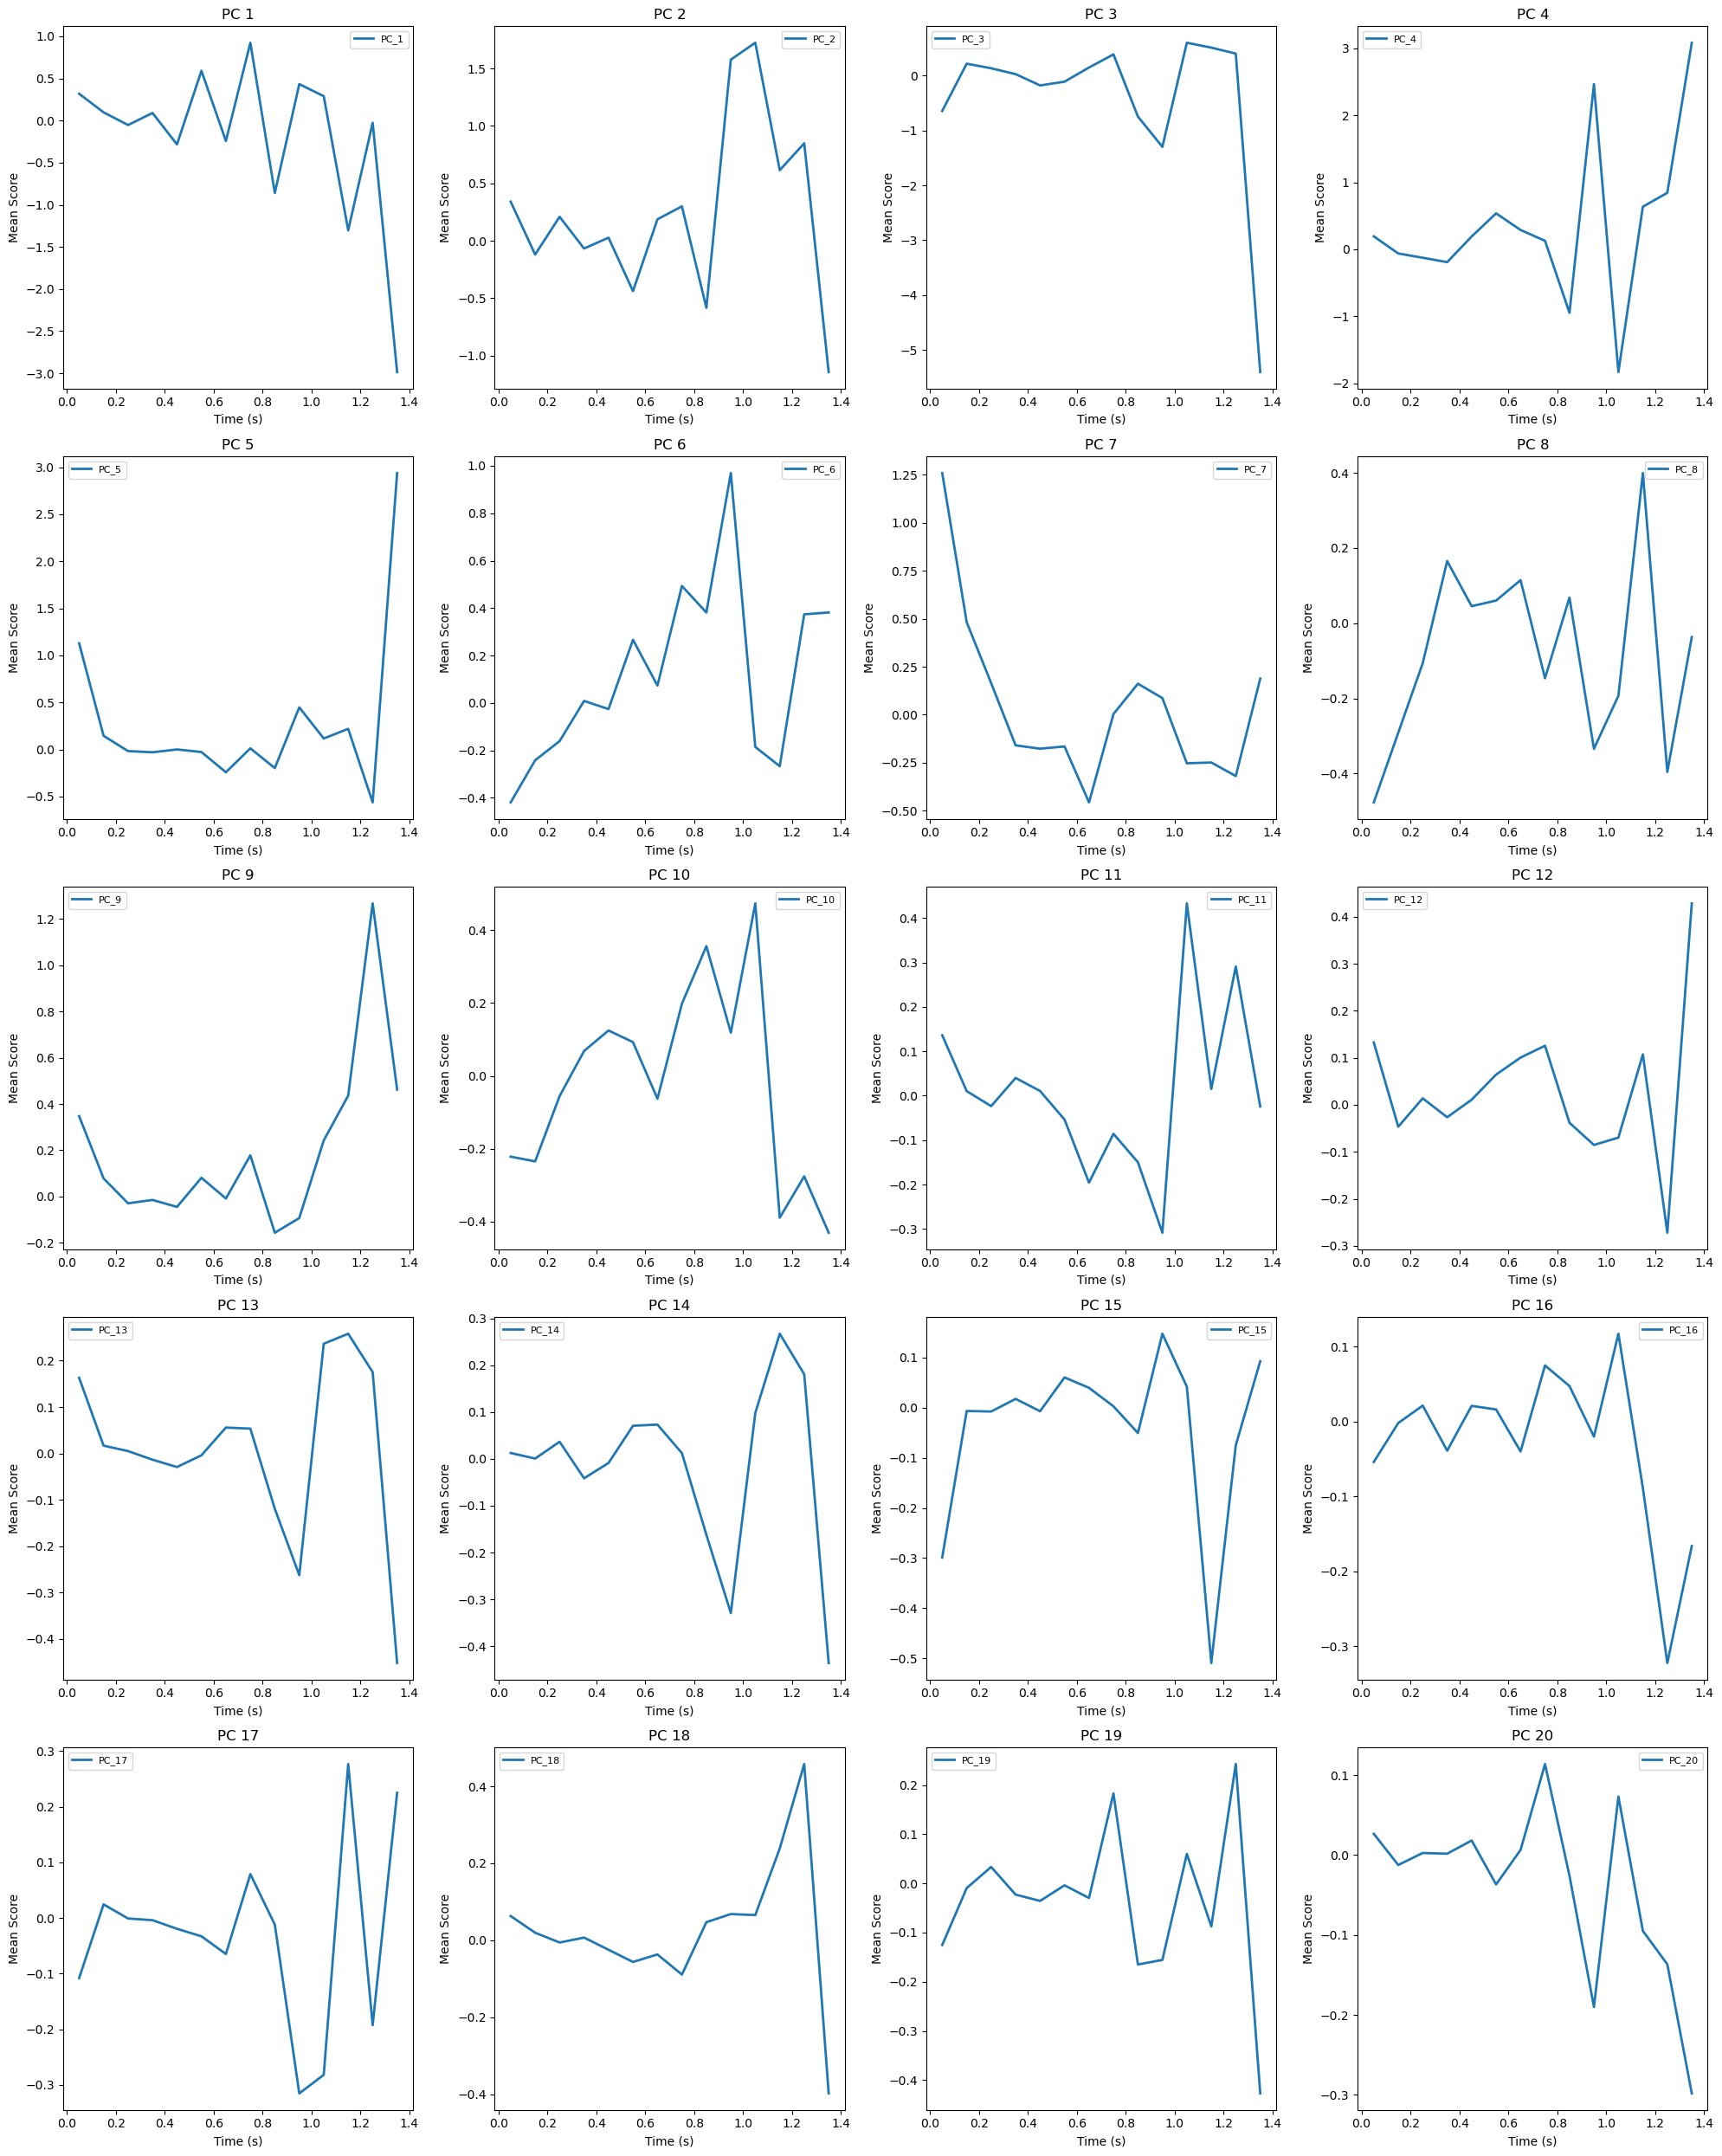

In [47]:
# Define the time range of interest and bin size
time_start, time_end = -0.5, 1.5
time_bins = np.arange(time_start, time_end, 0.1)  # Adjust bin size as needed (e.g., 0.1 seconds)

# Assuming `dict_output_df` contains a "fwhm_time" column and a "trial" column
time_column = dict_output_df["fwhm_time"]  # Adjust based on the actual name of the time column
trial_column = dict_output_df["trial"]    # Column that identifies trials

# Initialize storage for all trial results
trial_mean_scores = []

# Loop over unique trials
for trial in trial_column.unique():
    # Filter data for the current trial
    trial_mask = trial_column == trial
    trial_times = time_column[trial_mask]
    trial_pc_scores = pc_scores[trial_mask, :]
    
    # Initialize storage for the current trial
    mean_scores_per_bin = []
    bin_centers = []

    # Compute mean PC scores for each bin in the trial
    for i in range(len(time_bins) - 1):
        bin_start, bin_end = time_bins[i], time_bins[i + 1]
        bin_mask = (trial_times >= bin_start) & (trial_times < bin_end)
        if np.any(bin_mask):  # Ensure there are data points in the bin
            mean_scores_per_bin.append(trial_pc_scores[bin_mask].mean(axis=0))
        else:
            mean_scores_per_bin.append(np.full(pc_scores.shape[1], np.nan))  # Handle empty bins
        bin_centers.append((bin_start + bin_end) / 2)

    trial_mean_scores.append(mean_scores_per_bin)

# Convert results to a NumPy array (shape: trials x bins x PCs)
trial_mean_scores = np.array(trial_mean_scores)

# Average over trials (ignoring NaNs)
mean_scores_over_trials = np.nanmean(trial_mean_scores, axis=0)  # Shape: bins x PCs

# Plot averaged PC scores over time
f, ax = plt.subplots(5, 4, figsize=(20, 25))  # Create subplots for 20 PCs
ax = ax.flatten()

for pc_ix, pc in enumerate(pc_labels):
    ax[pc_ix].set_title(pc.replace("_", " "))  # Set PC title
    ax[pc_ix].plot(bin_centers, mean_scores_over_trials[:, pc_ix], lw=2, label=f"{pc}")  # Line plot of mean scores
    ax[pc_ix].set_xlabel("Time (s)")
    ax[pc_ix].set_ylabel("Mean Score")
    ax[pc_ix].legend(fontsize=8)

plt.tight_layout()
plt.show()


In [48]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def calculate_burst_rates(df_burst, condition, sensors, epoch, time_bin=0.05, time_buffer=0.125):
    """
    Calculate burst rates for specified conditions and sensors over time.
    
    Args:
        df_burst (DataFrame): DataFrame containing burst data.
        condition (str): Condition to filter bursts ('short' or 'long').
        sensors (list): List of sensors to include in burst counting.
        epoch (str): Epoch type ('stim' or 'resp').
        time_bin (float): Time bin size in seconds for counting bursts.
        time_buffer (float): Extra buffer time around epoch start and end.
    
    Returns:
        list: Burst rates (percentage change from baseline) for each subject.
    """
    # Define the time range
    time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)
    
    # Find the closest indices to -0.5 and 0 for baseline correction
    baseline_start = np.argmin(np.abs(time_range - (-0.3)))
    baseline_end = np.argmin(np.abs(time_range - (0)))

    # Filter the dataframe by condition, sensors, and epoch
    bursts = df_burst[(df_burst['condition'] == condition) & 
                      (df_burst['sensor'].isin(sensors)) & 
                      (df_burst['epochs'] == epoch)]
    subjects = bursts['subject'].unique()

    # Create a list to store burst rates for each subject
    burst_rates = []

    for subject in subjects:
        # Initialize an array for burst rates for the current subject
        subject_burst_rates = np.zeros(len(time_range))

        # Filter bursts for the current subject
        subject_df = bursts[bursts['subject'] == subject]

        for i, t in enumerate(time_range):
            # Count bursts across all sensors within the current time bin
            subject_burst_rates[i] = len(subject_df[(subject_df['peak_time'] >= t) & 
                                                    (subject_df['peak_time'] < t + time_bin)]) / time_bin

        # Smooth the burst rates
        subject_burst_rates_smoothed = gaussian_filter1d(subject_burst_rates, sigma=1)

        # Perform baseline correction
        baseline_mean = np.mean(subject_burst_rates_smoothed[baseline_start:baseline_end])
        subject_burst_rates_smoothed = ((subject_burst_rates_smoothed - baseline_mean) / baseline_mean) * 100
        
        # Append the smoothed burst rates for the current subject to the list
        burst_rates.append(subject_burst_rates_smoothed)

    return burst_rates


In [49]:
time_bin = 0.05
time_buffer = 0.125
burst_rates_stim_short = calculate_burst_rates(features_scores, condition='short', sensors = sensors, epoch='stim', time_bin=time_bin, time_buffer=time_buffer)
burst_rates_stim_long = calculate_burst_rates(features_scores, condition='long', sensors = sensors, epoch='stim', time_bin=time_bin, time_buffer=time_buffer)
burst_rates_resp_short = calculate_burst_rates(features_scores, condition='short', sensors = sensors, epoch='resp', time_bin=time_bin, time_buffer=time_buffer)
burst_rates_resp_long = calculate_burst_rates(features_scores, condition='long', sensors = sensors, epoch='resp', time_bin=time_bin, time_buffer=time_buffer)

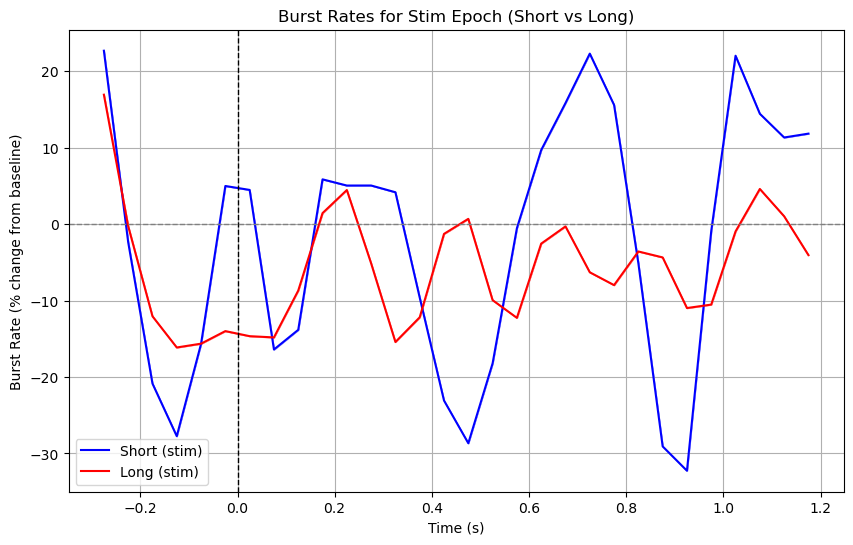

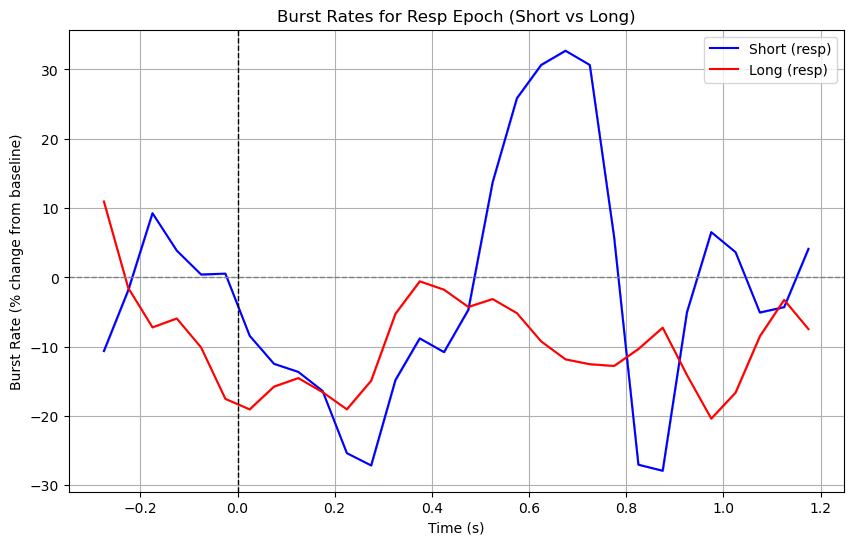

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_burst_rates(time_range, burst_rates_short, burst_rates_long, epoch):
    """
    Plot burst rates for short and long conditions for a specific epoch.

    Args:
        time_range (numpy array): Array of time points.
        burst_rates_short (list): List of burst rates for 'short' condition.
        burst_rates_long (list): List of burst rates for 'long' condition.
        epoch (str): Epoch name ('stim' or 'resp').
    """
    # Compute mean and standard error across subjects
    mean_short = np.mean(burst_rates_short, axis=0)
    sem_short = np.std(burst_rates_short, axis=0) / np.sqrt(len(burst_rates_short))

    mean_long = np.mean(burst_rates_long, axis=0)
    sem_long = np.std(burst_rates_long, axis=0) / np.sqrt(len(burst_rates_long))

    # Restrict time range to -0.3 to 1.2
    valid_indices = (time_range >= -0.3) & (time_range <= 1.2)
    time_range = time_range[valid_indices]
    mean_short = mean_short[valid_indices]
    sem_short = sem_short[valid_indices]
    mean_long = mean_long[valid_indices]
    sem_long = sem_long[valid_indices]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_range, mean_short, label=f'Short ({epoch})', color='blue')
    plt.fill_between(time_range, mean_short - sem_short, mean_short + sem_short, color='blue', alpha=0.3)

    plt.plot(time_range, mean_long, label=f'Long ({epoch})', color='red')
    plt.fill_between(time_range, mean_long - sem_long, mean_long + sem_long, color='red', alpha=0.3)

    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Time (s)')
    plt.ylabel('Burst Rate (% change from baseline)')
    plt.title(f'Burst Rates for {epoch.capitalize()} Epoch (Short vs Long)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the time range for plotting
time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)

# Plot burst rates for stim epochs
plot_burst_rates(time_range, burst_rates_stim_short, burst_rates_stim_long, epoch='stim')

# Plot burst rates for resp epochs
plot_burst_rates(time_range, burst_rates_resp_short, burst_rates_resp_long, epoch='resp')


In [51]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd

def calculate_burst_rates_by_pc_quartiles(df_burst, condition, sensors, epoch, pc_column, time_bin=0.05, time_buffer=0.125):
    """
    Calculate and baseline correct burst rates from burst peak times within each quartile of a specified PC score.
    
    Parameters:
    df_burst (DataFrame): DataFrame containing burst information with columns ['condition', 'sensor', 'epochs', 'subject', 'peak_time', pc_column].
    condition (str): Condition identifier ('short' or 'long').
    sensors (list): List of sensors to include in the analysis.
    epoch (str): Epoch identifier ('stim' or 'resp').
    pc_column (str): Column name for the PC score (e.g., 'PC_1').
    time_bin (float): Time bin size in seconds (default is 0.05).
    time_buffer (float): Time buffer around the epoch in seconds (default is 0.125).

    Returns:
    dict: A dictionary where keys are quartiles (1, 2, 3, 4) and values are lists of arrays containing smoothed and baseline-corrected burst rates for each subject in that quartile.
    """
    
    # Define the time range including buffer around the epoch
    time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)
    
    # Find the indices corresponding to the baseline period (-0.5 to 0 seconds)
    baseline_start = np.argmin(np.abs(time_range - (-0.3)))
    baseline_end = np.argmin(np.abs(time_range - 0))
    
    # Filter the DataFrame for the specified condition, sensors, and epoch
    bursts = df_burst[(df_burst['condition'] == condition) & 
                      (df_burst['sensor'].isin(sensors)) & 
                      (df_burst['epochs'] == epoch)].copy()
    
    if bursts.empty:
        raise ValueError("No burst data found for the specified parameters.")
    
    # Determine quartiles for the specified PC score
    quartiles = pd.qcut(bursts[pc_column], 4, labels=False) + 1
    bursts['quartile'] = quartiles
    
    # Prepare a dictionary to store burst rates for each quartile
    burst_rates_by_quartile = {1: [], 2: [], 3: [], 4: []}

    subjects = bursts['subject'].unique()
    
    for quartile in range(1, 5):
        for subject in subjects:
            # Initialize burst rate array for the current subject
            subject_burst_rates = np.zeros(len(time_range))
            subject_df = bursts[(bursts['subject'] == subject) & (bursts['quartile'] == quartile)]

            for i, t in enumerate(time_range):
                subject_burst_rates[i] = len(subject_df[(subject_df['peak_time'] >= t) & 
                                                        (subject_df['peak_time'] < t + time_bin)]) / time_bin
            
            # Apply Gaussian smoothing to the burst rates
            subject_burst_rates_smoothed = gaussian_filter1d(subject_burst_rates, sigma=1)
            
            # Perform baseline correction
            baseline_mean = np.mean(subject_burst_rates_smoothed[baseline_start:baseline_end])
            if baseline_mean != 0:
                subject_burst_rates_smoothed = ((subject_burst_rates_smoothed - baseline_mean) / baseline_mean) * 100
            
            burst_rates_by_quartile[quartile].append(subject_burst_rates_smoothed)

    return burst_rates_by_quartile


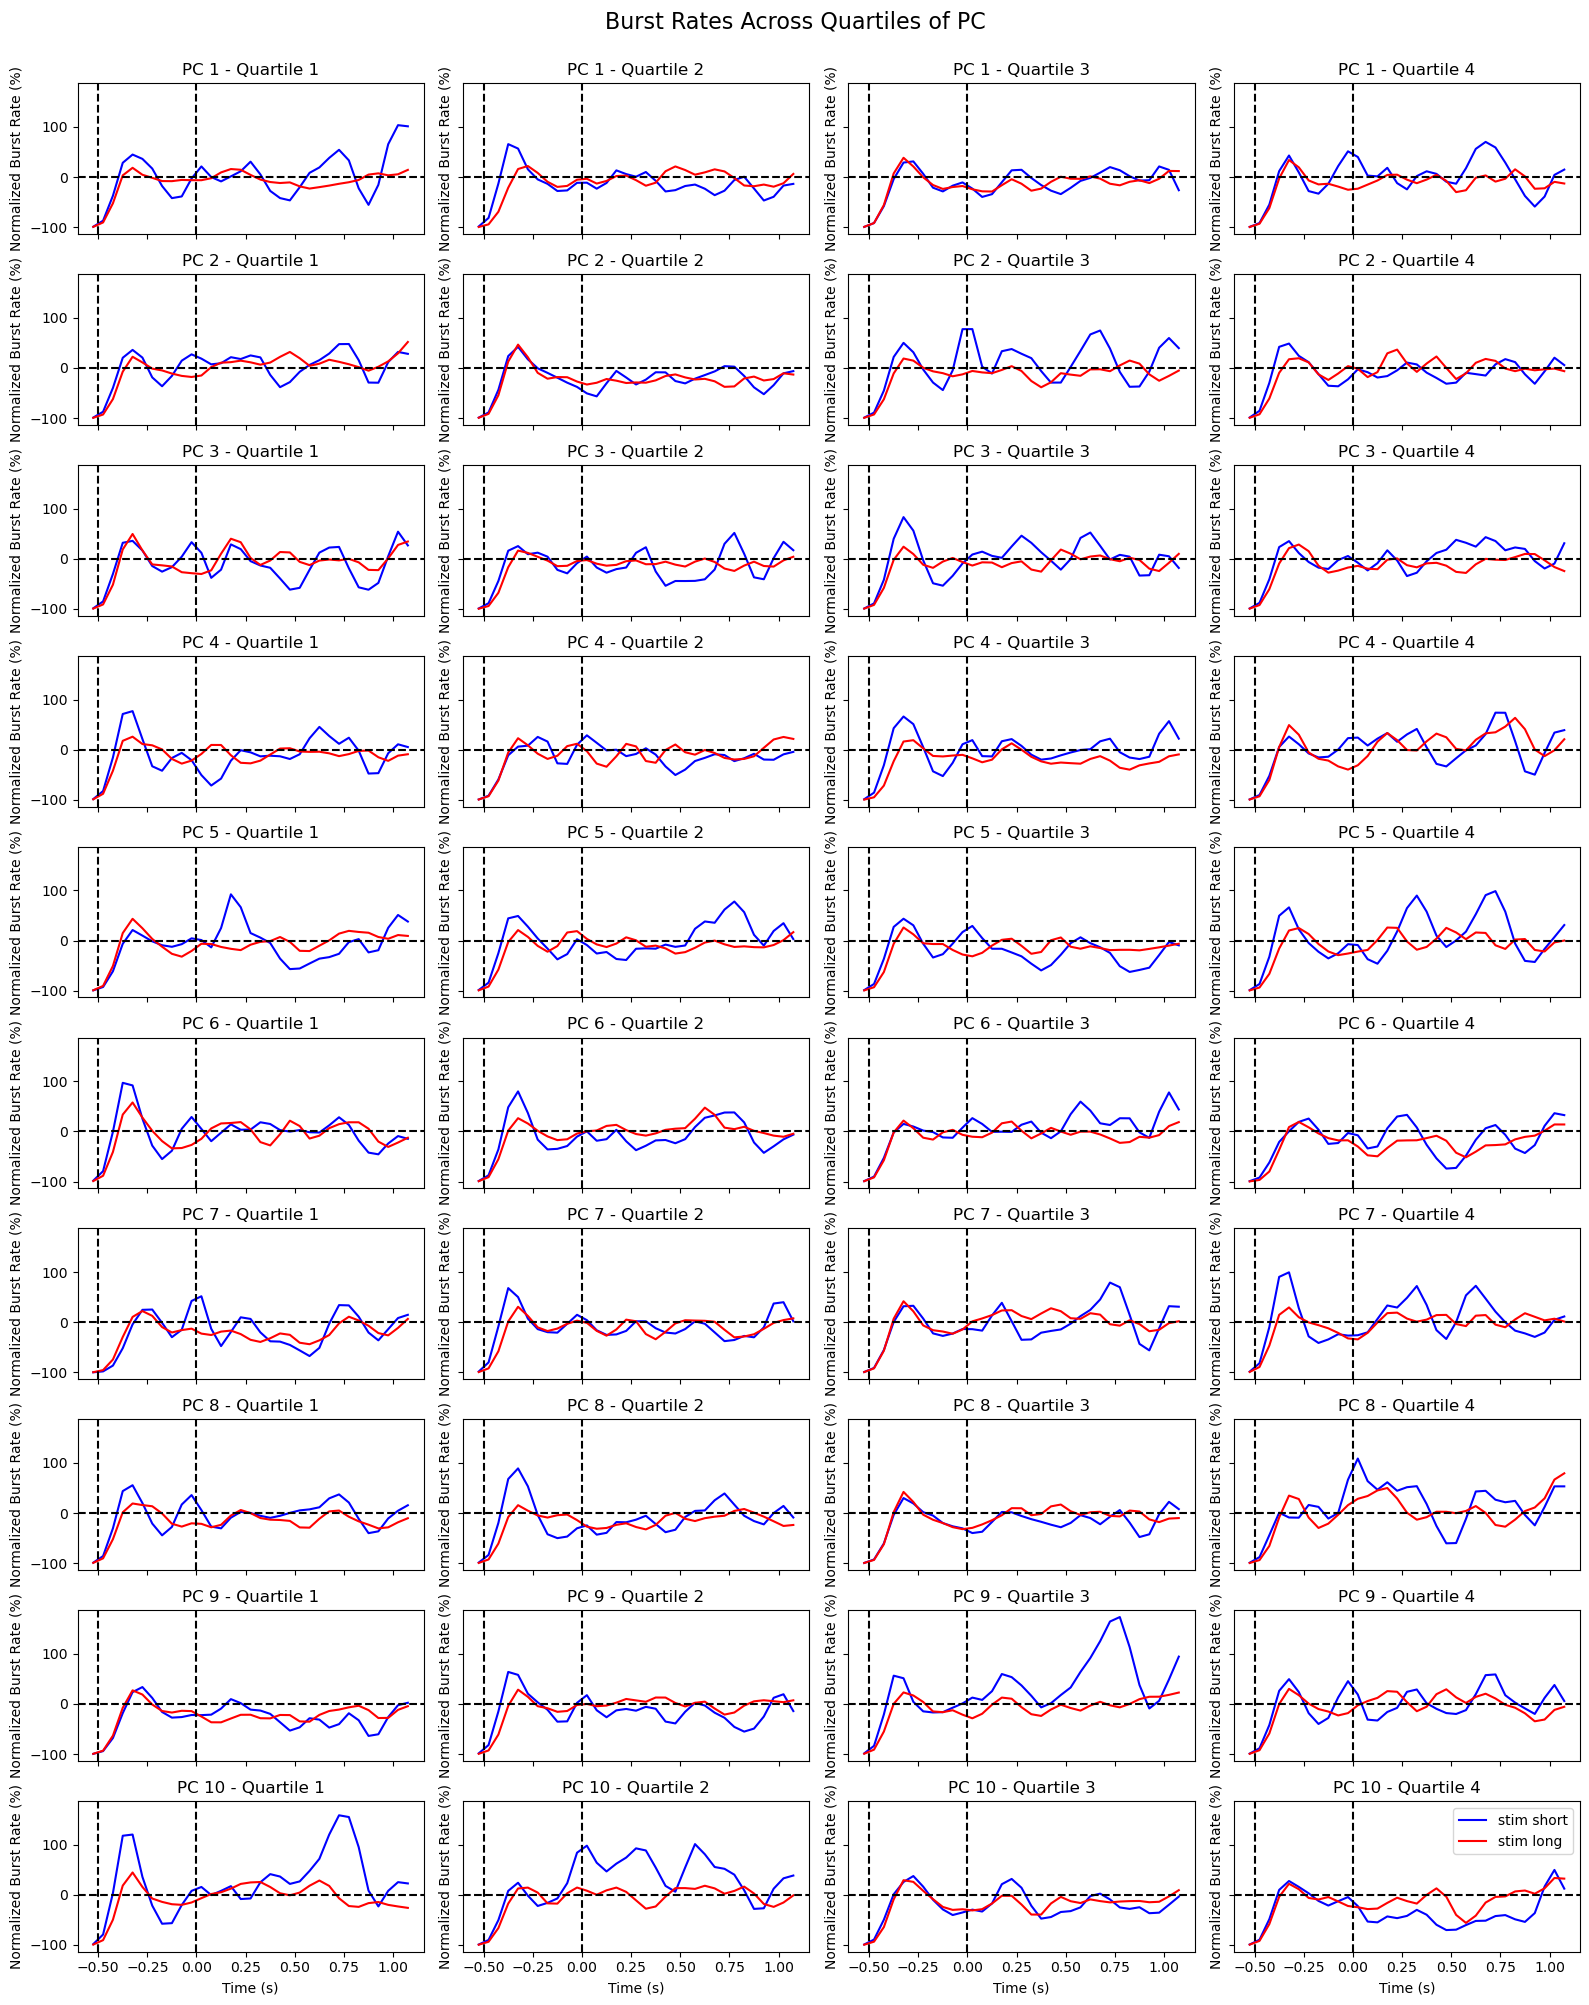

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
from scipy.stats import f_oneway

# Parameters
num_pcs = 10

# Create a single figure with subplots
fig, axes = plt.subplots(num_pcs, 4, figsize=(16, 20), sharex='col', sharey='all')

time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
selected_time_points = time_range[12:45]

# Iterate over each PC
for pc in range(1, num_pcs + 1):
    # Calculate burst rates by quartiles for the current PC for each condition
    burst_rates_stim_short = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='short',
        sensors=sensors,  # Replace with relevant sensors
        epoch='stim',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )

    burst_rates_stim_long = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='long',
        sensors=sensors,  # Replace with relevant sensors
        epoch='stim',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )
    
    
    # Iterate over each quartile
    for quartile, ax in zip(range(1, 5), axes[pc - 1]):
        # Plot burst rates for short stim condition
        mean_burst_rate_stim_short = np.mean(burst_rates_stim_short[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_stim_short[12:45], label='stim short', color='blue')

        # Plot burst rates for long stim condition
        mean_burst_rate_stim_long = np.mean(burst_rates_stim_long[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_stim_long[12:45], label='stim long', color='red')
        
        ax.axvline(x=0, color='k', linestyle='--')
        ax.axvline(x=-0.5, color='k', linestyle='--')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylabel('Normalized Burst Rate (%)')
        ax.set_title(f'PC {pc} - Quartile {quartile}')

# Set x-axis label for the last row of subplots
for ax in axes[-1]:
    ax.set_xlabel('Time (s)')

# Show legend only on the last subplot
axes[-1, -1].legend()

# Add a title
fig.suptitle('Burst Rates Across Quartiles of PC', fontsize=16, y=1)

# Adjust layout
plt.tight_layout()
plt.show()


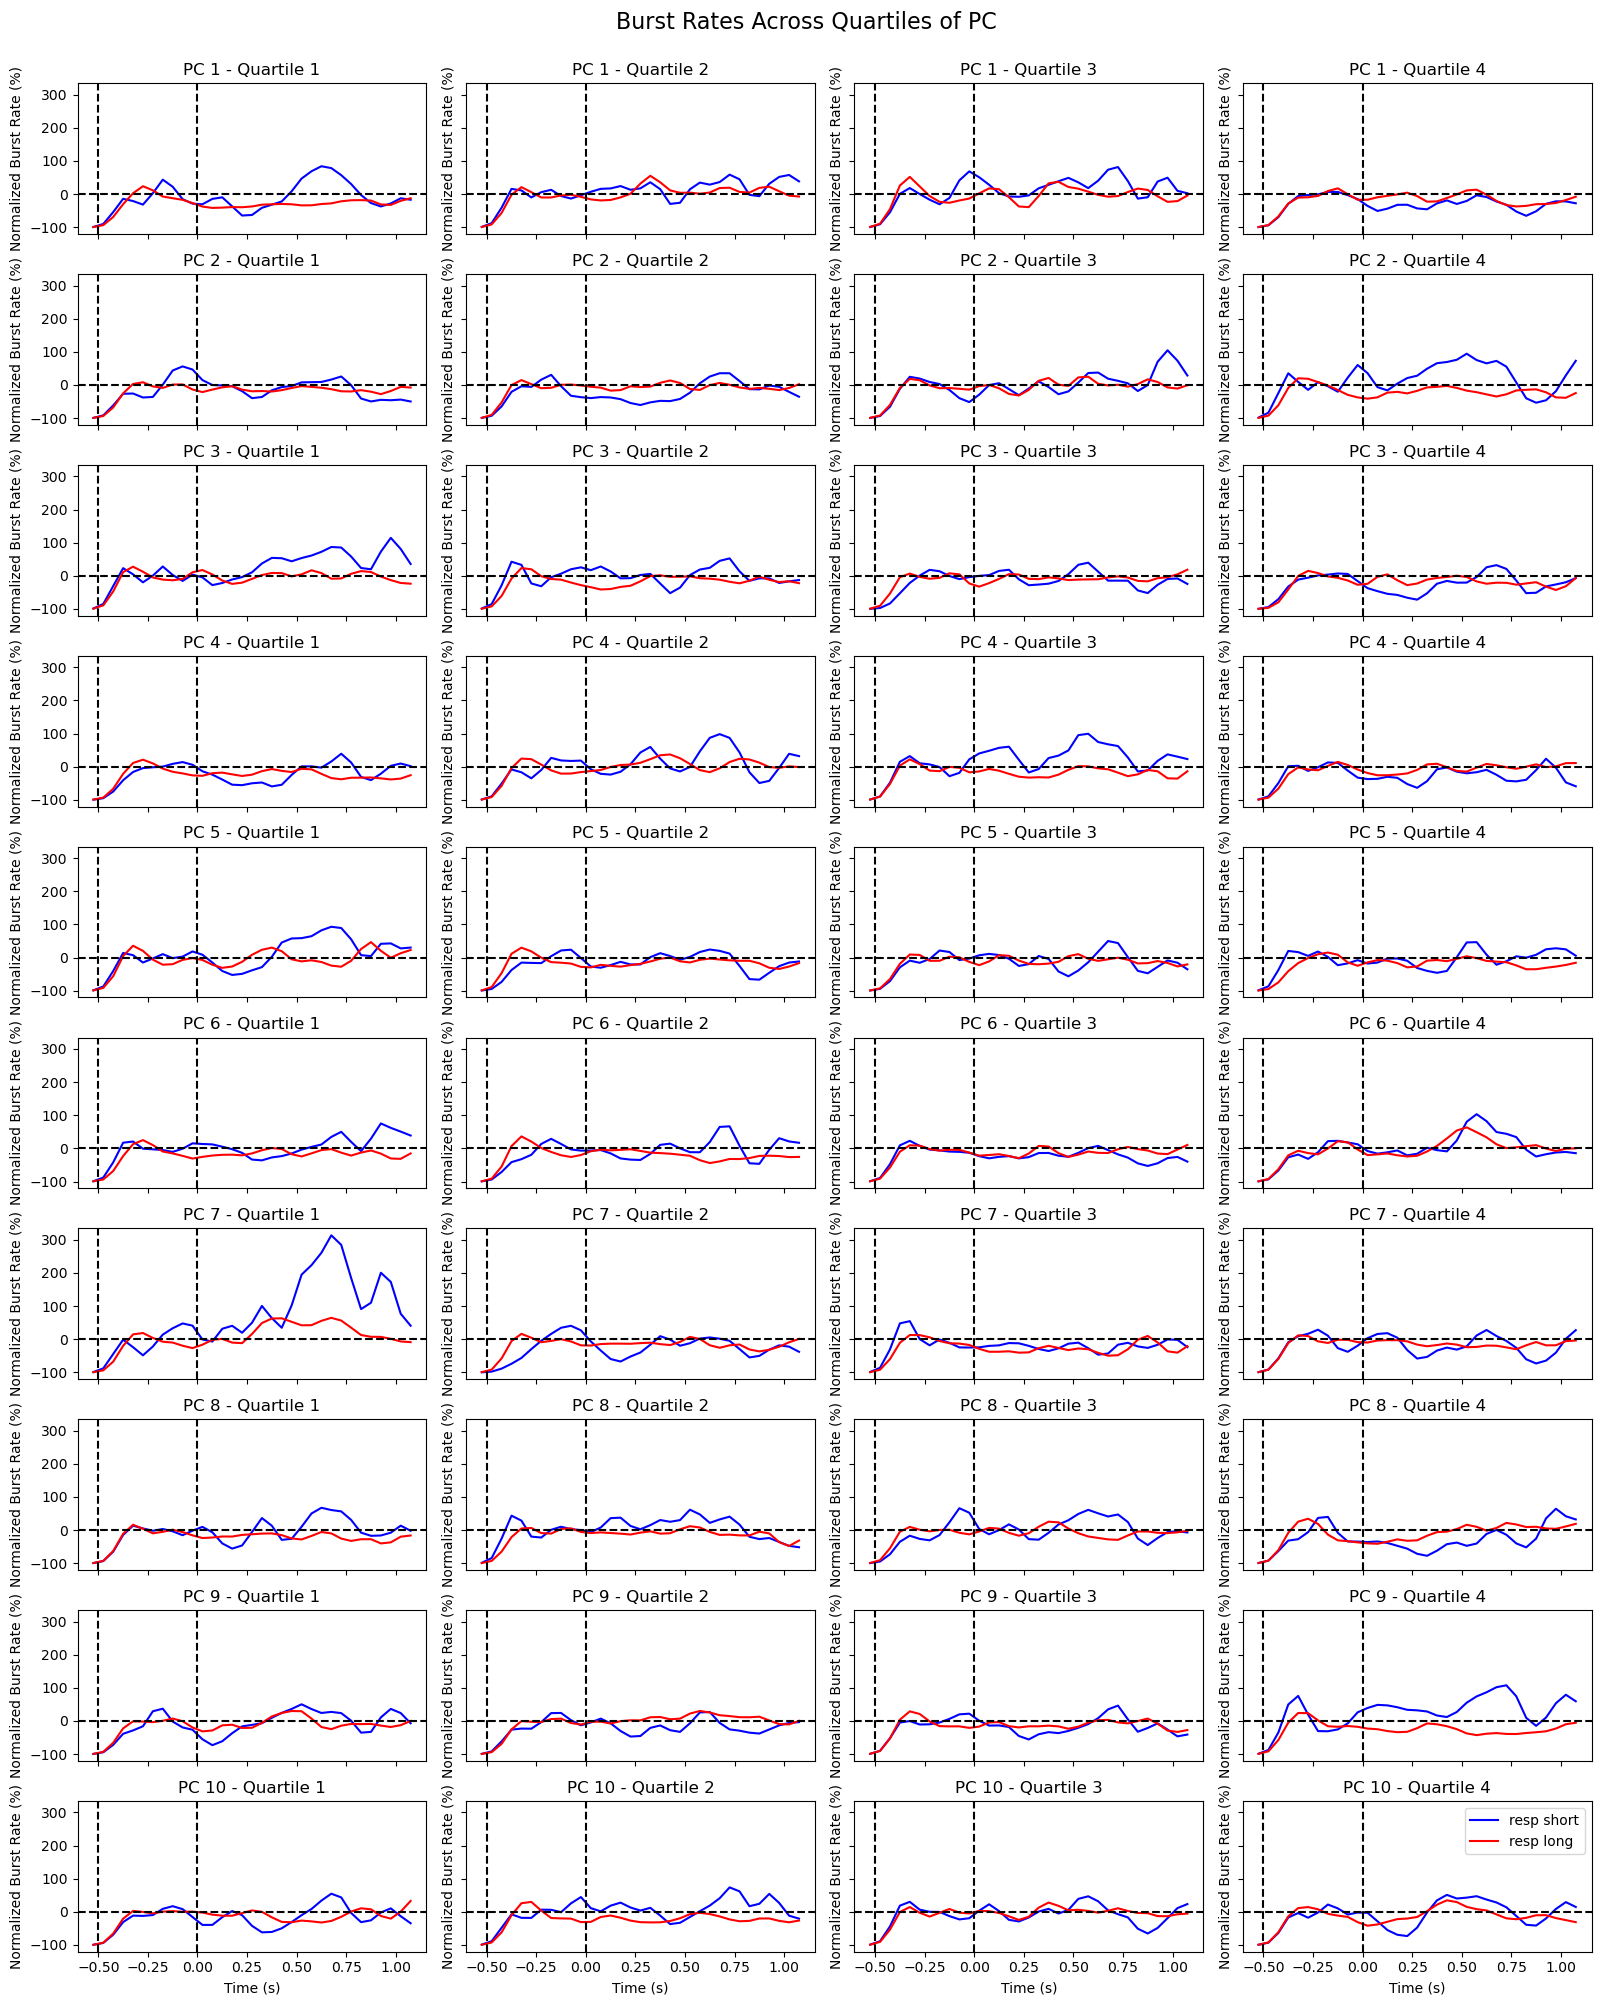

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
from scipy.stats import f_oneway

# Parameters
num_pcs = 10

# Create a single figure with subplots
fig, axes = plt.subplots(num_pcs, 4, figsize=(16, 20), sharex='col', sharey='all')

time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
selected_time_points = time_range[12:45]

# Iterate over each PC
for pc in range(1, num_pcs + 1):
    # Calculate burst rates by quartiles for the current PC for each condition
    burst_rates_resp_short = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='short',
        sensors=sensors,  # Replace with relevant sensors
        epoch='resp',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )

    burst_rates_resp_long = calculate_burst_rates_by_pc_quartiles(
        features_scores,
        condition='long',
        sensors=sensors,  # Replace with relevant sensors
        epoch='resp',  # Replace with relevant epoch
        pc_column=f'PC_{pc}'
    )
    
    
    # Iterate over each quartile
    for quartile, ax in zip(range(1, 5), axes[pc - 1]):
        # Plot burst rates for short resp condition
        mean_burst_rate_resp_short = np.mean(burst_rates_resp_short[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_resp_short[12:45], label='resp short', color='blue')

        # Plot burst rates for long resp condition
        mean_burst_rate_resp_long = np.mean(burst_rates_resp_long[quartile], axis=0)
        ax.plot(time_range[12:45], mean_burst_rate_resp_long[12:45], label='resp long', color='red')
        
        ax.axvline(x=0, color='k', linestyle='--')
        ax.axvline(x=-0.5, color='k', linestyle='--')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylabel('Normalized Burst Rate (%)')
        ax.set_title(f'PC {pc} - Quartile {quartile}')

# Set x-axis label for the last row of subplots
for ax in axes[-1]:
    ax.set_xlabel('Time (s)')

# Show legend only on the last subplot
axes[-1, -1].legend()

# Add a title
fig.suptitle('Burst Rates Across Quartiles of PC', fontsize=16, y=1)

# Adjust layout
plt.tight_layout()
plt.show()
